### Self Attention in Transformers 

In [576]:
import numpy as np
import math

seq_len, d_k, d_v = 4, 8, 8

q = np.random.randn(seq_len, d_k)
k = np.random.randn(seq_len, d_k)
v = np.random.randn(seq_len, d_v)

<!-- Here lets say, I am taking the sentence as "My name is Venu" which has 4 seq length and the dimensionality of each word I am taking is 8.
What I am doing is - >
My - 8 vector
name - 8 vector
is - 8 vector
venu - 8 vector

seq_len - It indicates the number of tokens (or words) in the sequence you're processing.
d_k and d_v are the dimensions of the query (Q), key (K), and value (V) vectors, respectively. Specifically, d_k is the dimension of the query and key vectors, and d_v is the dimension of the value vectors.
In the context of the Transformer’s attention mechanism:

For each position in the sequence, the model creates a query, key, and value vector.
L sets how many such vectors are created in parallel, one for each position in the sequence.
In practical terms, if you were working with a sentence with 4 tokens, you might set L = 4. Then each word or token would have its own query, key, and value vectors with dimensions d_k and d_v. -->

In [577]:
import torch

In [1]:
print("Q\n", q)
print("K\n", k)
print("V\n", v)

NameError: name 'q' is not defined

### Self Attention

Attention(Q, K, V) = softmax(d_q * d_k^T / sqrt(d_k) + M) * d_v

1. The + M term in the attention formula is typically a mask matrix. This matrix is used to selectively ignore certain positions in the sequence, which is particularly important in the following contexts:

2. Padding Mask - In sequences of varying lengths, shorter sequences are often padded to a uniform length for batch processing. The mask M can be used to prevent attention from being calculated on these padding tokens by assigning them a large negative value (often -inf), so that their softmax probability approaches zero, effectively ignoring them in the attention calculation.

3. Causal Mask (Look-Ahead Mask): In autoregressive tasks like language generation or translation, a mask is used to ensure that a token only attends to tokens that come before it in the sequence. This mask prevents a token from "seeing the future" by setting a large negative value for tokens that are beyond the current token’s position. 

In both cases, the mask M typically has:

0 values at positions where attention is allowed.
-inf values at positions to be masked, so their contribution to the softmax becomes zero.



In [579]:
q.shape, k.T.shape

((4, 8), (8, 4))

In [118]:
np.matmul(q, k.T)

array([[-0.95971972,  7.87945147, -3.93452496, -0.05834295],
       [-1.21077604, -0.04276918, -1.06859527,  0.98246685],
       [-3.80418985,  4.01712605,  0.55547391,  3.13794416],
       [ 7.55853039,  3.9686184 ,  6.31776681, -3.10309881]])

In [119]:
# why we need sqrt(d_k) in denominator
q.var(), k.var(), np.matmul(q, k.T).var()
# we could see that the varance of q and k are close to 1 while matmul of q and k.t vector multiplication is high when compared to only q and v

(1.4140272561320588, 1.0252924850927356, 13.728931728356509)

In [120]:
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
scaled

array([[-0.33931216,  2.78580678, -1.39106464, -0.02062735],
       [-0.42807398, -0.01512119, -0.37780548,  0.34735449],
       [-1.34498422,  1.42026854,  0.19638968,  1.1094308 ],
       [ 2.67234405,  1.40311849,  2.23366788, -1.09711111]])

In [121]:
q.var(), k.var(), scaled.var()

(1.4140272561320588, 1.0252924850927356, 1.7161164660445631)

#### Masking

M term in the attention formula is typically a mask matrix. This matrix is used to selectively ignore certain positions in the sequence, which is particularly important in the following contexts:

1. Padding Mask - In sequences of varying lengths, shorter sequences are often padded to a uniform length for batch processing. The mask M can be used to prevent attention from being calculated on these padding tokens by assigning them a large negative value (often -inf), so that their softmax probability approaches zero, effectively ignoring them in the attention calculation.

2. Causal Mask (Look-Ahead Mask): In autoregressive tasks like language generation or translation, a mask is used to ensure that a token only attends to tokens that come before it in the sequence. This mask prevents a token from "seeing the future" by setting a large negative value for tokens that are beyond the current token’s position. 

In [122]:
mask = np.tril(np.ones((seq_len,seq_len)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [123]:
mask[mask == 0] = -np.inf
mask[mask == 1] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [124]:
scaled + mask

array([[-0.33931216,        -inf,        -inf,        -inf],
       [-0.42807398, -0.01512119,        -inf,        -inf],
       [-1.34498422,  1.42026854,  0.19638968,        -inf],
       [ 2.67234405,  1.40311849,  2.23366788, -1.09711111]])

#### Softmax Function

In [125]:
def softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis = -1)).T

In [126]:
attention = softmax(scaled + mask)
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.39820431, 0.60179569, 0.        , 0.        ],
       [0.04639498, 0.73689393, 0.21671109, 0.        ],
       [0.51308274, 0.14420149, 0.33088171, 0.01183406]])

In [127]:
qkv_attention = np.matmul(attention, v)
qkv_attention, qkv_attention.shape

(array([[-1.38196193, -1.23322893,  1.77097453,  0.67421384, -0.2475888 ,
          1.26165014,  0.24105605, -1.24267933],
        [-0.81034213,  0.50163253, -0.05860093,  0.31941135, -0.25340329,
          1.14114286, -0.71447318,  0.27828631],
        [-0.48896668,  0.91407827, -0.79182161,  0.14412254, -0.1280293 ,
          0.950327  , -0.90291641,  0.97749284],
        [-0.93439501, -0.75798635,  0.83101505,  0.4281438 , -0.04282717,
          0.98464847,  0.06616976, -0.31738712]]),
 (4, 8))

In [128]:
v

array([[-1.38196193, -1.23322893,  1.77097453,  0.67421384, -0.2475888 ,
         1.26165014,  0.24105605, -1.24267933],
       [-0.432105  ,  1.64957912, -1.26921916,  0.08464085, -0.2572507 ,
         1.06140397, -1.34674069,  1.28469942],
       [-0.49113792, -1.1271732 ,  0.28283719,  0.23289567,  0.336965  ,
         0.50597608,  0.36133287,  0.40819193],
       [-0.04355718,  0.83245748,  0.99680307, -0.59573238,  0.8286883 ,
         1.42328971,  1.44765476, -0.00917915]])

Attention(Q, K, V) = softmax(d_q * d_k^T / sqrt(d_k) + M) * d_v


In [ ]:
# # Function for the scaled dot product attention

# def scaled_dot_product_attention(q, k, v, mask = None):
#     d_k = q.shape[-1]
#     scaled = np.matmul(q, k.T) / math.sqrt(d_k)
#     if mask is not None:
#         scaled = scaled + mask
#     attention = softmax(scaled)
#     qkv_attention = np.matmul(attention, v)
#     return qkv_attention, attention
    

In [130]:
scaled_dot_product_attention(q, k, v, mask = mask)

(array([[-1.38196193, -1.23322893,  1.77097453,  0.67421384, -0.2475888 ,
          1.26165014,  0.24105605, -1.24267933],
        [-0.81034213,  0.50163253, -0.05860093,  0.31941135, -0.25340329,
          1.14114286, -0.71447318,  0.27828631],
        [-0.48896668,  0.91407827, -0.79182161,  0.14412254, -0.1280293 ,
          0.950327  , -0.90291641,  0.97749284],
        [-0.93439501, -0.75798635,  0.83101505,  0.4281438 , -0.04282717,
          0.98464847,  0.06616976, -0.31738712]]),
 array([[1.        , 0.        , 0.        , 0.        ],
        [0.39820431, 0.60179569, 0.        , 0.        ],
        [0.04639498, 0.73689393, 0.21671109, 0.        ],
        [0.51308274, 0.14420149, 0.33088171, 0.01183406]]))

### Multi Head Attention

In [580]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [581]:
seq_length = 4
batch_size = 1
input_dim = 512
d_model = 512

x = torch.randn((batch_size, seq_len, input_dim))
x.shape

torch.Size([1, 4, 512])

In [582]:
qkv_layer = nn.Linear(input_dim, 3*d_model)

In [583]:
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'QKV Distribution')

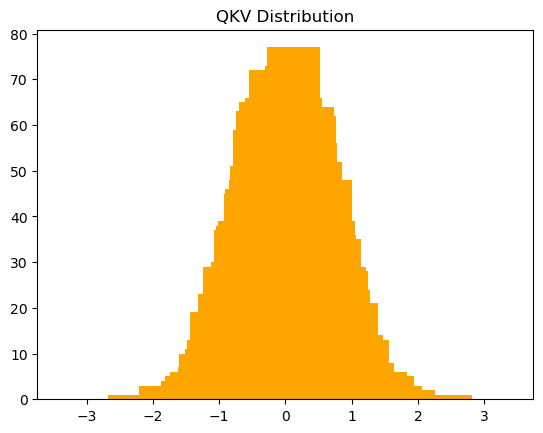

In [584]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 400, min = -3, max = 3)
x_val = np.linspace(-3, 3, 400)
plt.bar(x_val, y_val, align = 'center', color = ['orange'])
plt.title("QKV Distribution")

In [585]:
num_heads = 8
head_dim = d_model // num_heads
head_dim
# Now we have to break down the last dimension into
# num_of_heads x q,k,v dimension (head_dimension)

64

In [586]:
qkv = qkv.reshape(batch_size, seq_length, num_heads, 3* head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [587]:
qkv = qkv.permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [588]:
q,k,v = qkv.chunk(3, dim= -1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

#### Self Attention for Multiple Heads

Attention(Q, K, V) = softmax((Q . KT/√d_k) + M )V

In [589]:
d_k = q.size()[-1]
d_k

64

In [590]:
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape
scaled[0][0]

tensor([[ 0.4098,  0.1451,  0.4211,  0.0320],
        [ 0.0304,  0.1343, -0.4155,  0.4881],
        [ 0.1012,  0.1963, -0.2875, -0.4380],
        [-0.2518, -0.3250,  0.3760,  0.0851]], grad_fn=<SelectBackward0>)

In [591]:
mask = torch.full(scaled.size(), float("-inf"))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [592]:
(scaled + mask)[0][1]

tensor([[-0.1903,    -inf,    -inf,    -inf],
        [-0.4248,  0.1303,    -inf,    -inf],
        [-0.2464, -0.2115, -0.6710,    -inf],
        [-0.5323, -0.3889,  0.1952, -0.4244]], grad_fn=<SelectBackward0>)

In [593]:
scaled += mask

In [594]:
attention = F.softmax(scaled, dim = -1)
attention.shape
attention[0][1]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3647, 0.6353, 0.0000, 0.0000],
        [0.3718, 0.3850, 0.2432, 0.0000],
        [0.1873, 0.2162, 0.3878, 0.2087]], grad_fn=<SelectBackward0>)

In [595]:
print(attention.shape, v.shape)
print(torch.matmul(attention, v).shape)

torch.Size([1, 8, 4, 4]) torch.Size([1, 8, 4, 64])
torch.Size([1, 8, 4, 64])


In [ ]:
# def scaled_dot_product(q, k, v, mask = None):
#     d_k = k.size()[-1]
#     scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
#     if mask is not None:
#         scaled += mask
#     attention = F.softmax(scaled, dim = -1)
#     new_values = torch.matmul(attention, v)
#     return attention, new_values

In [148]:
# For Encoder
attention, new_values = scaled_dot_product(q, k, v, mask= mask)
attention.shape, new_values.shape

(torch.Size([1, 8, 4, 4]), torch.Size([1, 8, 4, 64]))

In [149]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6135, 0.3865, 0.0000, 0.0000],
        [0.2830, 0.4525, 0.2645, 0.0000],
        [0.3335, 0.1443, 0.1772, 0.3450]], grad_fn=<SelectBackward0>)

In [150]:
# For Decoder
d_attention, d_new_values = scaled_dot_product(q, k, v, mask= None)
d_attention.shape, d_new_values.shape

(torch.Size([1, 8, 4, 4]), torch.Size([1, 8, 4, 64]))

In [151]:
d_attention[0][0]

tensor([[0.1357, 0.3607, 0.1863, 0.3172],
        [0.2963, 0.1866, 0.2099, 0.3072],
        [0.1978, 0.3162, 0.1848, 0.3012],
        [0.3335, 0.1443, 0.1772, 0.3450]], grad_fn=<SelectBackward0>)

In [152]:
# Now we will combine all of the heads together
new_values = new_values.reshape(batch_size, seq_length, num_heads * head_dim)
new_values.shape

torch.Size([1, 4, 512])

In [153]:
# We will pass it through FF layer so that they can communicate with each other
ffn_layer = nn.Linear(d_model, d_model)
out_ffn_layer = ffn_layer(new_values)
out_ffn_layer.shape # the output vector will be much more context aware now than the input as we have passed it through a ffn

torch.Size([1, 4, 512])

In [154]:
from torch import nn

In [745]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x)
        print(f"x after activation: {x.size()}")
        x = self.dropout(x)
        print(f"x after dropout: {x.size()}")
        x = self.linear2(x)
        print(f"x after 2nd linear layer: {x.size()}")
        return x

In [ ]:
# class MultiHeadAttention(nn.Module):
    
#     def __init__(self, input_dim, d_model, num_heads):
#         super().__init__()
#         self.input_dim = input_dim
#         self.d_model = d_model
#         self.num_heads = num_heads
#         self.head_dim = d_model // num_heads
#         self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
#         self.linear_layer = nn.Linear(d_model, d_model)

#     def forward(self, x, mask = None):
#         print(f"x.shape in attention layer = {x.shape}")
#         batch_size, seq_length, input_dim = x.size()
#         qkv = self.qkv_layer(x)
#         print(f"qkv torch matrix of x is - {qkv.size()}")
#         qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
#         print(f"qkv torch matrix reshaped shape is : {qkv.size()}")
#         qkv = qkv.permute(0,2,1,3)
#         print(f"Permutted qkv shape is - {qkv.size()}")
#         q,k,v = qkv.chunk(3, dim = -1)
#         print("The shape of q,k,v matrix is below - ")
#         print(f"q - {q.size()}")
#         print(f"k - {k.size()}")
#         print(f"v - {v.size()}")
#         attention, new_values = scaled_dot_product(q, k, v, mask)
#         print(f"Attention Size - {attention.size()}, New Values Size is - {new_values.size()}")
#         new_values = new_values.reshape(batch_size, seq_length, self.num_heads * self.head_dim)
#         print(f"Reshaped New Values shape - {new_values.size()}")
#         out = self.linear_layer(new_values)
#         print(f"Output from the FF Layer is  - {out.shape}")
#         return out
        




In [597]:
input_dim = 1024
d_model = 1024
num_heads = 8

batch_size = 32
seq_length = 20
x = torch.randn(batch_size, seq_length, input_dim)
print(x.shape)

torch.Size([32, 20, 1024])


In [158]:
model = MultiHeadAttention(input_dim= input_dim, num_heads= num_heads, d_model= d_model)
ouput_multi_head_attention = model.forward(x)

x.shape in attention layer = torch.Size([32, 20, 1024])
qkv torch matrix of x is - torch.Size([32, 20, 3072])
qkv torch matrix reshaped shape is : torch.Size([32, 20, 8, 384])
Permutted qkv shape is - torch.Size([32, 8, 20, 384])
The shape of q,k,v matrix is below - 
q - torch.Size([32, 8, 20, 128])
k - torch.Size([32, 8, 20, 128])
v - torch.Size([32, 8, 20, 128])
Attention Size - torch.Size([32, 8, 20, 20]), New Values Size is - torch.Size([32, 8, 20, 128])
Reshaped New Values shape - torch.Size([32, 20, 1024])
Output from the FF Layer is  - torch.Size([32, 20, 1024])


#### Positional Encoding

In [598]:
import torch
import torch.nn as nn

In [599]:
max_seq_length = 10
d_model = 10

### Position Encoding Formula

#### Even Positions (sin)

### PE(pos, 2i) = sin(pos / 10000^(2i/d))

#### Odd Positions (cos)

### PE(pos, 2i+1) = cos(pos / 10000^(2i/d))

#### Variables

* PE: Position encoding
* pos: Position in sequence
* i: Dimension index
* d: Embedding dimension


#### We can also write the position encoding formula as

#### Even Positions (sin)

### PE(pos, i) = sin(pos / 10000^(i/d_model))

#### Odd Positions (cos)

### PE(pos, i) = cos(pos / 10000^(i - 1/d_model))

In [600]:
even_i = torch.arange(0, d_model, 2).float()
even_i

tensor([0., 2., 4., 6., 8.])

In [601]:
odd_i = even_i + 1
odd_i

tensor([1., 3., 5., 7., 9.])

In [602]:
even_denominator = torch.pow(10000, even_i / d_model)
even_denominator

tensor([1.0000e+00, 6.3096e+00, 3.9811e+01, 2.5119e+02, 1.5849e+03])

In [603]:
odd_denominator = torch.pow(10000, (odd_i - 1) / d_model)
odd_denominator

tensor([1.0000e+00, 6.3096e+00, 3.9811e+01, 2.5119e+02, 1.5849e+03])

In [604]:
## even_denominator and odd_denominator are the same! So we can just do one of these actions and call the resulting variable denominator

In [605]:
denominator = even_denominator

In [606]:
position = torch.arange(max_seq_length, dtype = torch.float).reshape(max_seq_length, 1)
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [607]:
even_position_emb = torch.sin(position / denominator)
odd_position_emb = torch.cos(position / denominator)

In [608]:
even_position_emb, even_position_emb.shape

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  1.5783e-01,  2.5116e-02,  3.9811e-03,  6.3096e-04],
         [ 9.0930e-01,  3.1170e-01,  5.0217e-02,  7.9621e-03,  1.2619e-03],
         [ 1.4112e-01,  4.5775e-01,  7.5285e-02,  1.1943e-02,  1.8929e-03],
         [-7.5680e-01,  5.9234e-01,  1.0031e-01,  1.5924e-02,  2.5238e-03],
         [-9.5892e-01,  7.1207e-01,  1.2526e-01,  1.9904e-02,  3.1548e-03],
         [-2.7942e-01,  8.1396e-01,  1.5014e-01,  2.3884e-02,  3.7857e-03],
         [ 6.5699e-01,  8.9544e-01,  1.7493e-01,  2.7864e-02,  4.4167e-03],
         [ 9.8936e-01,  9.5448e-01,  1.9960e-01,  3.1843e-02,  5.0476e-03],
         [ 4.1212e-01,  9.8959e-01,  2.2415e-01,  3.5822e-02,  5.6786e-03]]),
 torch.Size([10, 5]))

In [609]:
odd_position_emb, odd_position_emb.shape

(tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
         [ 0.5403,  0.9875,  0.9997,  1.0000,  1.0000],
         [-0.4161,  0.9502,  0.9987,  1.0000,  1.0000],
         [-0.9900,  0.8891,  0.9972,  0.9999,  1.0000],
         [-0.6536,  0.8057,  0.9950,  0.9999,  1.0000],
         [ 0.2837,  0.7021,  0.9921,  0.9998,  1.0000],
         [ 0.9602,  0.5809,  0.9887,  0.9997,  1.0000],
         [ 0.7539,  0.4452,  0.9846,  0.9996,  1.0000],
         [-0.1455,  0.2983,  0.9799,  0.9995,  1.0000],
         [-0.9111,  0.1439,  0.9746,  0.9994,  1.0000]]),
 torch.Size([10, 5]))

In [610]:
stacked = torch.stack([even_position_emb, odd_position_emb], dim= 2)

PE = torch.flatten(stacked, start_dim= 1, end_dim= 2)
PE, PE.shape

(tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  1.5783e-01,  9.8747e-01,  2.5116e-02,
           9.9968e-01,  3.9811e-03,  9.9999e-01,  6.3096e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  3.1170e-01,  9.5018e-01,  5.0217e-02,
           9.9874e-01,  7.9621e-03,  9.9997e-01,  1.2619e-03,  1.0000e+00],
         [ 1.4112e-01, -9.8999e-01,  4.5775e-01,  8.8908e-01,  7.5285e-02,
           9.9716e-01,  1.1943e-02,  9.9993e-01,  1.8929e-03,  1.0000e+00],
         [-7.5680e-01, -6.5364e-01,  5.9234e-01,  8.0569e-01,  1.0031e-01,
           9.9496e-01,  1.5924e-02,  9.9987e-01,  2.5238e-03,  1.0000e+00],
         [-9.5892e-01,  2.8366e-01,  7.1207e-01,  7.0211e-01,  1.2526e-01,
           9.9212e-01,  1.9904e-02,  9.9980e-01,  3.1548e-03,  1.0000e+00],
         [-2.7942e-01,  9.6017e-01,  8.1396e-01,  5.8092e-01,  1.5014e-01,
           9.8866e-

In [746]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.d_model = d_model

        # Compute the position encodings
        even_i = torch.arange(0, d_model, 2).float()
        denominator = torch.pow(10000, even_i / d_model)
        position = torch.arange(max_seq_length).reshape(max_seq_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        self.position_encoding = torch.flatten(stacked, start_dim=1, end_dim=2)  # Shape: [max_seq_length, d_model]
        #print(f"[DEBUG] Initial position encoding shape: {self.position_encoding.shape}")

    def forward(self, x):
        # Get the batch size and sequence length
        batch_size, seq_len, d_model = x.size(0), x.size(1), x.size(2)
        #print(f"[DEBUG] Input tensor shape: batch_size={batch_size}, seq_len={seq_len}, d_model={d_model}")

        # Check the dimensions of position_encoding
        position_encoding = self.position_encoding[:seq_len, :]  # Shape: [seq_len, d_model]
        #print(f"[DEBUG] Sliced position encoding shape: {position_encoding.shape}")

        # Ensure that the position encoding is broadcastable across the batch dimension
        position_encoding = position_encoding.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: [batch_size, seq_len, d_model]
        #print(f"[DEBUG] Broadcasted position encoding shape: {position_encoding.shape}")
        
        # Perform the addition and verify the output shape
        output = x + position_encoding
        #print(f"[DEBUG] Output tensor shape after addition: {output.shape}")

        return output


In [612]:
batch_size = 32
seq_len = 34
d_model = 512
max_seq_length = 200

x = torch.randn(batch_size, seq_len, d_model)
position_encoding = torch.randn(max_seq_length, d_model)

position_encoding_sliced = position_encoding[:seq_len, :]

position_encoding_sliced_expanded = position_encoding_sliced.unsqueeze(0).expand(batch_size, -1, -1)

output = x + position_encoding_sliced_expanded

x.shape, output.shape, position_encoding_sliced_expanded.shape

(torch.Size([32, 34, 512]),
 torch.Size([32, 34, 512]),
 torch.Size([32, 34, 512]))

In [613]:
position_encoder = PositionEncoding(d_model=d_model, max_seq_length=max_seq_length)
output = position_encoder(x)
x.shape, output.shape

(torch.Size([32, 34, 512]), torch.Size([32, 34, 512]))

### Layer Normalization

In [614]:
import torch
from torch import nn

In [615]:
inputs = torch.tensor([[[0.1,0.2,0.3], [0.5,0.6,0.7]]])
print(inputs.size())
B, S, E = inputs.size()
inputs = inputs.reshape(S, B, E)
inputs, inputs.shape

torch.Size([1, 2, 3])


(tensor([[[0.1000, 0.2000, 0.3000]],
 
         [[0.5000, 0.6000, 0.7000]]]),
 torch.Size([2, 1, 3]))

In [616]:
parameter_shape = inputs.size()[-2:]
print(parameter_shape)
gamma = nn.Parameter(torch.ones(parameter_shape))
beta = nn.Parameter(torch.zeros(parameter_shape))
print(gamma.shape)
print(beta.shape)
gamma, beta

torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])


(Parameter containing:
 tensor([[1., 1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 0.]], requires_grad=True))

In [617]:
dims = [-(i+1) for i in range(len(parameter_shape))]
dims

[-1, -2]

In [618]:
mean = inputs.mean(dim = dims, keepdim= True)
print(mean)
mean.size()

tensor([[[0.2000]],

        [[0.6000]]])


torch.Size([2, 1, 1])

In [619]:
var = ((inputs - mean) **2).mean(dim = dims, keepdim=True)
epsilon = 1e-5
std = (var+epsilon).sqrt()
std

tensor([[[0.0817]],

        [[0.0817]]])

In [620]:
y = (inputs - mean) / std
y

tensor([[[-1.2238e+00,  0.0000e+00,  1.2238e+00]],

        [[-1.2238e+00,  7.2946e-07,  1.2238e+00]]])

In [621]:
out = gamma * y + beta
out

tensor([[[-1.2238e+00,  0.0000e+00,  1.2238e+00]],

        [[-1.2238e+00,  7.2946e-07,  1.2238e+00]]], grad_fn=<AddBackward0>)

In [747]:
class LayerNormalization(nn.Module):
    def __init__(self, parameter_shape, eps = 1e-5):
        super().__init__()
        self.parameters_shape = parameter_shape
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(parameter_shape))
        self.beta = nn.Parameter(torch.zeros(parameter_shape))

    def forward(self, input):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim = dims, keepdim= True)
        print(f"Mean of inputs is - {mean.size()}\n Mean value is - {mean}")
        var = ((inputs - mean) ** 2).mean(dim = dims, keepdim= True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation is \n {std.size()}\n std value is - {std}")
        y = (input - mean) / std
        print(f"y is {y}\n The shape of y is {y.size()}")
        out = self.gamma * y + self.beta
        print(f"The output is {out.size()}\n The shape of output is {out.size()}")


In [623]:
batch_size = 10
seq_length = 5
embedding_dim = 15
inputs = torch.randn(seq_length, batch_size, embedding_dim)
inputs.shape

torch.Size([5, 10, 15])

In [624]:
layer_norm = LayerNormalization(inputs.size()[-1:])
layer_norm

LayerNormalization()

In [625]:
out = layer_norm.forward(inputs)

Mean of inputs is - torch.Size([5, 10, 1])
 Mean value is - tensor([[[ 0.3235],
         [ 0.1398],
         [-0.3515],
         [ 0.1191],
         [ 0.1709],
         [-0.0468],
         [ 0.0245],
         [ 0.4237],
         [-0.1499],
         [-0.1170]],

        [[ 0.1430],
         [ 0.2185],
         [ 0.0465],
         [ 0.2267],
         [-0.0661],
         [-0.1528],
         [-0.0760],
         [ 0.3744],
         [-0.3958],
         [ 0.0744]],

        [[-0.1501],
         [-0.2867],
         [ 0.4361],
         [-0.0888],
         [ 0.0412],
         [-0.1105],
         [-0.4728],
         [ 0.0483],
         [ 0.4540],
         [ 0.1632]],

        [[ 0.3820],
         [ 0.0926],
         [ 0.1274],
         [ 0.3634],
         [ 0.0671],
         [-0.1880],
         [ 0.0761],
         [-0.2325],
         [-0.0337],
         [-0.2985]],

        [[-0.0218],
         [-0.0569],
         [ 0.5496],
         [ 0.2421],
         [ 0.1891],
         [-0.1433],
         [ 0

### Transformer Encoder Layer

In [626]:
import torch
import math
from torch import nn
import torch.nn.functional as F

In [748]:
def scaled_dot_product(q, k, v, mask=None):
    print(f"Initial Query shape: {q.shape}")
    print(f"Initial Key shape: {k.shape}")
    print(f"Initial Value shape: {v.shape}")

    # Compute the scaled dot-product
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    print(f"Scaled dot product (q * k^T) shape: {scaled.shape}")

    if mask is not None:
        print(f"Mask shape before broadcasting: {mask.shape}")
        # If mask has 3 dimensions (batch_size, seq_len, seq_len), it might need an additional dimension for broadcasting
        if mask.ndimension() == 3:
            print(f"Mask has 3 dimensions, adding additional singleton dimensions for multi-head attention.")
            mask = mask.unsqueeze(1)  # Add singleton dimension for multi-head (batch_size, 1, seq_len, seq_len)
            print(f"Mask shape after unsqueeze(1): {mask.shape}")
        
        # Check the compatibility of the mask and scaled tensor
        print(f"Scaled tensor shape before adding mask: {scaled.shape}")
        print(f"Mask shape before adding: {mask.shape}")

        scaled += mask  # Broadcast the mask to the scaled tensor
        print(f"Scaled tensor shape after adding mask: {scaled.shape}")

    # Apply softmax to the scaled tensor
    attention = F.softmax(scaled, dim=-1)
    print(f"Attention (after softmax) shape: {attention.shape}")

    # Multiply the attention with values
    print(f"Shape of scaled tensor before matmul with values: {scaled.shape}")
    print(f"Shape of value tensor (v): {v.shape}")
    values = torch.matmul(scaled, v)
    print(f"Output values shape: {values.shape}")

    return attention, values


In [749]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self,num_heads, d_model):
        super().__init__()
        self.d_model = d_model # 512
        self.num_heads = num_heads # 8
        self.head_dim = d_model//num_heads # 64
        self.qkv_layer = nn.Linear(d_model, 3*d_model) # 512 x 1536
        self.linear_layer = nn.Linear(d_model, d_model) # 512 x 512

    def forward(self, x, mask = None):
        print(f"x.shape = {x.shape}")
        batch_size, max_seq_length, d_model = x.size()
        batch_size, max_seq_length, d_model = x.size()
        print(f"x.size() = {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"x after going through qkv layer - {qkv.size()}")
        qkv_reshape  = qkv.reshape(batch_size, max_seq_length, self.num_heads, 3*self.head_dim)
        print("--- Entering MultiHeadedAttention ---")
        print(f"qkv reshaped shape is {qkv_reshape.size()}")
        qkv_permute = qkv_reshape.permute(0,2,1,3)
        print(f"QKV Permuted Shape is - {qkv_permute.size()}")
        print("--- Dividing QKV into individual tensors ---")
        q, k, v = qkv_permute.chunk(3, dim = -1)
        print("Now q, k, v tensors are passed into the Attention Calculation")
        attention, values = scaled_dot_product(q, k, v, mask = mask)
        print("Now we get the Attention Scores and New Values")
        print(f"Values shape we get from scaled dot product attention is - {values.size()}")
        print("Now we concatinate the values received from scaled dot product.")
        values_reshaped = values.permute(0,2,1,3).reshape(batch_size, max_seq_length, self.num_heads * self.head_dim)
        print(f"New Values from Multiheaded attention output shape is - {values_reshaped.size()}")
        output = self.linear_layer(values_reshaped)
        print(f"Final Output shape from multiheaded attention heads - {output.size()}")
        return output


In [750]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps = 1e-5):
        super().__init__()
        self.paramters_shape = parameters_shape
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta = nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.paramters_shape))]
        mean = inputs.mean(dim = dims, keepdim = True)
        print(f"Shape of the Mean after preserving the dimensions - {mean.size()}")
        var = ((inputs - mean)**2).mean(dim = dims, keepdim = True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation is {std.size()}")
        normalized_out = (inputs - mean) / std
        normalized_out = (normalized_out * self.gamma) + self.beta
        print("Normalized value is Multiplied and Added with Learnable Parameters Gamma and Beta") 
        print(f"Shape of gamma and beta are - {self.gamma.size()} and {self.beta.size()}")
        print(f"Layer Normalized Output shape is {normalized_out.size()}")
        return normalized_out



In [751]:
## Putting it all together 
class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super().__init__()
        self.attention_layer = MultiHeadAttention(num_heads=num_heads, d_model=d_model)
        self.layer_normalizer1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p = drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_normalizer2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p = drop_prob)

    def forward(self, x, mask = None):
        residual_x = x
        print("----- Attention Layer 1 ----")
        x = self.attention_layer(x, mask = mask)
        print(f"Output shape from Multi Head Attention - {x.size()}")
        print("---- Dropout 1 ----")
        x = self.dropout1(x)
        print(f"x shape after passing through dropout Layer 1 - {x.size()}")
        print("----- Add and Normalizer 1 ---")
        x = self.layer_normalizer1(residual_x + x)
        print(f"x shape after passing through layer normalizer 1 - {x.size()}")
        residual_x = x
        print("---- Attention 2 through ffn ----")
        x = self.ffn(x)
        print("----- Dropout 2 -----")
        x = self.dropout2(x)
        print("----- Add and Normalizer 2 ---")
        x = self.layer_normalizer2(residual_x + x)
        return x

In [752]:
## Encoder Block

class EncoderBlock(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(* [EncoderLayer(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob= drop_prob) 
                                       for _ in range(num_layers)])
    
    def forward(self, x, mask = None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [633]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 32
max_seq_length = 200
ffn_hidden = 2048
num_layers = 5

In [634]:
encoder = EncoderBlock(d_model, ffn_hidden, num_heads,drop_prob, num_layers)

In [635]:
# create a dummy x randn input
x = torch.randn((batch_size, max_seq_length, d_model))
print(x.size())

torch.Size([32, 200, 512])


In [636]:
encoder_output = encoder(x)

----- Attention Layer 1 ----
x.shape = torch.Size([32, 200, 512])
x.size() = torch.Size([32, 200, 512])
x after going through qkv layer - torch.Size([32, 200, 1536])
--- Entering MultiHeadedAttention ---
qkv reshaped shape is torch.Size([32, 200, 8, 192])
QKV Permuted Shape is - torch.Size([32, 8, 200, 192])
--- Dividing QKV into individual tensors ---
Now q, k, v tensors are passed into the Attention Calculation
Initial Query shape: torch.Size([32, 8, 200, 64])
Initial Key shape: torch.Size([32, 8, 200, 64])
Initial Value shape: torch.Size([32, 8, 200, 64])
Scaled dot product (q * k^T) shape: torch.Size([32, 8, 200, 200])
Attention (after softmax) shape: torch.Size([32, 8, 200, 200])
Shape of scaled tensor before matmul with values: torch.Size([32, 8, 200, 200])
Shape of value tensor (v): torch.Size([32, 8, 200, 64])
Output values shape: torch.Size([32, 8, 200, 64])
Now we get the Attention Scores and New Values
Values shape we get from scaled dot product attention is - torch.Size([32

### Multi Headed Cross Attention

In [753]:
class MultiHeadedCrossAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model, 2 * d_model)
        self.q_layer = nn.Linear(d_model, d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask = None):
        batch_size, max_seq_length, d_model = x.size()
        print("This is the input to the Decoder Layer")
        print(f"The shape of the input x which comes from Encoder is {x.size()}")
        kv = self.kv_layer(x)
        print("The Keys and Values for Cross Attention will be coming from Encoder Layer")
        print(f"The shape of kv is {kv.size()}")
        q = self.q_layer(y)
        print("The y which is the query matrix will be coming from the masked self attention head from Decoder.")
        print(f"The shape of q is {q.size()}")
        kv = kv.reshape(batch_size, max_seq_length, num_heads, 2* self.head_dim)
        q = q.reshape(batch_size, max_seq_length, num_heads, self.head_dim)
        # q shape is 30 x 200 x 8 x 64
        # k, v shape is 30 x 200 x 8 x 128
        # The shape we want is q = 30 x 8 x 200 x 64
        # The shape we want for k, v = 30 x 8 x 200 x 128
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim = -1)
        # the shape of k, v = 30 x 8 x 200 x 64
        attention, values = scaled_dot_product(q, k, v, mask = mask)
        print(f"Values and Attention shapes are {values.size()} and {attention.size()}")
        values = values.permute(0,2,1,3).reshape(batch_size, max_seq_length, self.num_heads * self.head_dim)
        print(f"The contextualized values will be reshaped by 'values.reshape(batch_size, max_seq_length, self.num_heads * self.head_dim)'")
        print(f"The contextualized values will be of shape {values.size()}")
        out = self.linear_layer(values)
        print(f"Values passing through a linear leayer and returns output with shape - {out.size()}")
        return out # 30 x 200 x 512


### Decoder Layer

In [754]:
class DecoderLayer(nn.Module):
    def __init__(self,d_model, ffn_hidden, drop_prob, num_heads):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model,num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p = drop_prob)
        self.encoder_decoder_cross_attention = MultiHeadedCrossAttention(d_model = d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p = drop_prob)
        self.ffn = PositionwiseFeedForward(d_model = d_model,hidden=ffn_hidden,drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p = drop_prob)

    def forward(self, x, y, decoder_self_attention_mask = None, cross_attention_mask = None):
        residual_y = y # 30 x 200 x 512
        print("----ENTERING MASKED SELF ATTENTION----")
        y = self.self_attention(y, mask = decoder_self_attention_mask)
        print("---ENTERING DROPOUT 1---")
        y = self.dropout1(y) # 30 x 200 x 512
        print("---ENTERING LAYERNORM 1---")
        y = self.layer_norm1(residual_y + y) # 30 x 200 x 512

        residual_y = y
        print("---ENTERING CROSS ATTENTION---")
        y = self.encoder_decoder_cross_attention(x, y, mask = cross_attention_mask) # 30 x 200 x 512
        print("---ENTERING DROPOT 2---")
        y = self.dropout2(y)
        print("---ENTERING LAYERNORM 2---")
        y = self.layer_norm2(residual_y + y) # 30 x 200 x 512

        residual_y = y
        print("---ENTERING FEED FORWARD LAYER---")
        y = self.ffn(y)
        print("---ENTERING DROPOUT 3---")
        y = self.dropout3(y)
        print("---ENTERING LAYERNORM 3---")
        y = self.layer_norm3(residual_y + y)
        return y # 30 x 200 x 512


In [755]:
class SequentialDecoder(nn.Sequential):
#         self._modules is a dictionary of all the layers stored in the SequentialDecoder (inherited from nn.Sequential).
#         self._modules.values() gives a list of the layers in the order they were added.

    def forward(self, x, y, decoder_self_attention_mask=None, cross_attention_mask=None):
        for module in self._modules.values():
            y = module(x, y, decoder_self_attention_mask, cross_attention_mask)
        return y
        


In [756]:
class Decoder(nn.Sequential):
    def __init__(self, d_model, num_heads, ffn_hidden, drop_prob, num_layers=5):
        super().__init__()
        self.layers = SequentialDecoder(*[
            DecoderLayer(d_model=d_model,
                         ffn_hidden=ffn_hidden,
                         drop_prob=drop_prob,
                         num_heads=num_heads)
            for _ in range(num_layers)
        ])

    def forward(self, x, y, decoder_self_attention_mask=None, cross_attention_mask=None):
        # x shape is 30 x 200 x 512
        # y shape is 30 x 200 x 512
        return self.layers(x, y, decoder_self_attention_mask, cross_attention_mask)


In [641]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 32
max_seq_length = 200
ffn_hidden = 2048
num_layers = 1

In [642]:
x = torch.randn((batch_size, max_seq_length, d_model))
# x is the english words sent as input to the Encoder
y = torch.randn(batch_size, max_seq_length, d_model)
# y is the target language words sent as input to the Decoder
mask = torch.full([max_seq_length, max_seq_length], float("-inf"))
mask = torch.triu(mask, diagonal=1)

decoder = Decoder(d_model=d_model,
                  num_heads=num_heads,
                  ffn_hidden=ffn_hidden,
                  drop_prob=drop_prob,
                  num_layers=num_layers)

# Use the updated code
out = decoder(x, y, mask, mask)

----ENTERING MASKED SELF ATTENTION----
x.shape = torch.Size([32, 200, 512])
x.size() = torch.Size([32, 200, 512])
x after going through qkv layer - torch.Size([32, 200, 1536])
--- Entering MultiHeadedAttention ---
qkv reshaped shape is torch.Size([32, 200, 8, 192])
QKV Permuted Shape is - torch.Size([32, 8, 200, 192])
--- Dividing QKV into individual tensors ---
Now q, k, v tensors are passed into the Attention Calculation
Initial Query shape: torch.Size([32, 8, 200, 64])
Initial Key shape: torch.Size([32, 8, 200, 64])
Initial Value shape: torch.Size([32, 8, 200, 64])
Scaled dot product (q * k^T) shape: torch.Size([32, 8, 200, 200])
Mask shape before broadcasting: torch.Size([200, 200])
Scaled tensor shape before adding mask: torch.Size([32, 8, 200, 200])
Mask shape before adding: torch.Size([200, 200])
Scaled tensor shape after adding mask: torch.Size([32, 8, 200, 200])
Attention (after softmax) shape: torch.Size([32, 8, 200, 200])
Shape of scaled tensor before matmul with values: tor

### Sentence Tokenization

In [643]:
import torch
import numpy as np
import pandas

In [757]:
with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-te/English_Text.txt',"r") as f:
    english_text = f.readlines()

with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-te/Telugu_Text.txt',"r") as f:
    telugu_text = f.readlines()

In [758]:
english_text[-4:],telugu_text[-4:]

(['Heres a look at some of them. \n',
  'For this Rs. \n',
  'Everyone lives happily ever after. \n',
  '\n'],
 ['వాటిలో కొన్నిటిని మీకు అందిస్తున్నాము పరిశీలించండి. \n',
  'ఇందులో ఆహారం వండేందు కు రూ. \n',
  'అన్ని ప్రజలు తర్వాత ఎప్పుడైనా సంతోషంగా నివసిస్తున్నట్లు. \n',
  '\n'])

In [759]:
START_TOKEN = "[START]"
PADDING_TOKEN = "[PAD]"
END_TOKEN = "[END]"
UNK_TOKEN = "[UNK]"

In [760]:
telugu_vocab = [
    # Vowels
    START_TOKEN,"అ", "ఆ", "ఇ", "ఈ", "ఉ", "ఊ", "ఋ", "ౠ", "ఎ", "ఏ", "ఐ", "ఒ", "ఓ", "ఔ", "అం", "అః",
    
    # Consonants
    "క", "ఖ", "గ", "ఘ", "ఙ", 
    "చ", "ఛ", "జ", "ఝ", "ఞ", 
    "ట", "ఠ", "డ", "ఢ", "ణ", 
    "త", "థ", "ద", "ధ", "న", 
    "ప", "ఫ", "బ", "భ", "మ", 
    "య", "ర", "ల", "వ", 
    "శ", "ష", "స", "హ", "ళ", 
    "క్ష", "ఱ",

    # Diacritics (Gunintamulu)
    "ా", "ి", "ీ", "ు", "ూ", "ె", "ే", "ై", "ొ", "ో", "ౌ", "ం", "ః",
    
    # Special Characters
    "౦", "౧", "౨", "౩", "౪", "౫", "౬", "౭", "౮", "౯",  # Telugu digits
    "।", "॥", ":", ",", ".", "?", "!", "-", "—", ";", "\"", "\'"," ",
    
    # Common Words
    "నేను", "నువ్వు", "మీరు", "అతను", "ఆమె", "వారు", "ఇది", "అది", "మనం", "మనము",
    "ఇంటి", "పిల్లలు", "కుటుంబం", "పుస్తకం", "కలం", "ప్రభుత్వం", "రాష్ట్రం", 
    "పాఠశాల", "కళాశాల", "విద్యార్థి", "గురువు", "స్నేహితుడు", "పెద్ద", "చిన్న", 
    "అమ్మ", "నాన్న", "వెళ్ళు", "రా", "తెలుసు", "చూడు", "మాట్లాడు", "ఉండు", "ఇష్టం", 
    "వద్దు", "స్వాగతం", "శుభోదయం", "శుభ సాయంత్రం", "ధన్యవాదాలు", "క్షమించండి", "దయచేసి","పిల్లలు", "ప్రేమ", 
    "సందేహం", "సమయం", "వార్త", "పెద్దమనిషి", "ఆహారం", "నీరు", "మాట", "బయట", "లోపల", "దారి", "రహదారి", 
    "నగరం", "గ్రామం", "గది", "చేప", "పండు", "కూరగాయ", "ఆకులు", "పుష్పం", "జీవితం", "సందర్శన", "సంఘం", 
    "సంస్కృతి", "గమ్యం", "ప్రయాణం", "పని", "వాక్యం", "సమాధానం", "పరీక్ష", "తప్పు", "సరైనది", "చరిత్ర", "తనిఖీ", 
    "పాఠం", "కథ", "కోరిక", "మనం", "అభిప్రాయం", "ఉపాయం", "నేస్తం", "ఆనందం", "మహిళ", "పురుషుడు", "విద్య", 
    "సముద్రం", "వెలుగు", "నిజం", "అబద్దం", "నివేదిక", "శ్రద్ధ", "మార్పు", "విజయం", "అవకాశం", "సాహసం", "పోరాటం", 
    "అడుగు", "పట్టణం", "పట్టుదల", "సంకల్పం", "నిర్ణయం", "జ్ఞానం", "ఆశ", "ప్రయత్నం","ఆశ్చర్యం", "క్లేశం", "ఆహ్వానం", "భయంకరం", 
    "అందం", "సాహసము", "గుర్తు", "విజ్ఞానం", "సంబంధం", "ఆరోగ్యం", "కవిత", "భాష", "రంగం", "మంచి", "చెడు", "స్నేహం", 
    "గమనించు", "శక్తి", "బలహీనత", "తల్లి", "తండ్రి", "అన్న", "చెల్లి", "తమ్ముడు", "మాట్లాడు", "నవ్వు", "అరచు", "బావుందా", 
    "ఎక్కడ", "ఎప్పుడు", "ఎందుకు", "ఎలా", "ఎవరూ", "దారిని", "పోలీసు", "దేవుడు", "మతం", "నమ్మకం", "పుణ్యం", "పాపం", 
    "ఆసక్తి", "కృషి", "పరిశ్రమ", "ఆహారపదార్థం", "బంధం", "చెట్టు", "కొమ్మ", "కొబ్బరి", "విత్తనాలు", "ఆస్పత్రి", "వ్యాధి", "చికిత్స", 
    "డాక్టర్", "సందేహాలు", "పరిరక్షణ", "పౌరులు", "సమూహం", "తీర్పు", "ఆజ్ఞ", "అడుగు", "ఉచితం", "లాభం", "నష్టము", "చరిత్ర", 
    "సంబంధిత", "వీధి", "నోట్లు", "సంగీతం", "కళలు", "క్రీడలు", "పనిముట్లు", "సమయం", "కార్యక్రమం", "పరిశీలన", "పలుకరింపు", 
    "పశువులు", "జంతువులు", "పక్షులు", "అంతరిక్షం", "భూమి", "ప్లానెట్", "వాతావరణం", "నిబంధన", "న్యాయం", "కంప్యూటర్", "మిత్రుడు", 
    "ఉపాధి", "ప్రజలు","ఆకలి", "తలుపు", "ముళ్లు", "చెరువు", "మండలం", "విషయం", "గాలి", "దరువు", "రైలు", "పిట్ట", 
"అడవి", "నది", "పులి", "సింహం", "ఏనుగు", "జింక", "చందమామ", "నక్షత్రం", "గంట", "మంచు", 
"మేఘం", "మబ్బులు", "కార్తికం", "దీపాలు", "దీపావళి", "సంక్రాంతి", "దసరా", "హోలీ", "దేవాలయం", 
"పూజ", "అగ్ని", "రుద్రుడు", "విష్ణువు", "లక్ష్మి", "సరస్వతి", "శివుడు", "హనుమంతుడు", "రాముడు", 
"కృష్ణుడు", "అనంతం", "చిన్నపిల్ల", "గౌరవం", "నామకరణం", "కన్నీళ్లు", "స్వభావం", "కారణం", "క్లిష్టత", 
"ఉత్సాహం", "విజయం", "తీవ్రత", "ఆరంభం", "నిరుత్సాహం", "గంటల", "కాసులు", "స్నేహితురాలు", "తాత్కాలికం", "మరణం", 
"సుఖం", "నిట్టూర్పు", "ఆశ్చర్యం", "భయభీతులు", "ఉత్సాహవంతంగా", "ఆకర్షణ", "బహుమతి", "గెలుపు", "పోటీ", "జీవితం", 
"కలహం", "శాంతి", "నిర్బంధం", "ఆశయం", "ప్రగతి", "సంఘటనలు", "క్రమబద్ధత", "మితిమీరిన", "సౌకర్యం", "సమతూకం", 
"భావన", "మౌనం", "పూర్తి", "పగ", "వెండితెర", "సినిమాలు", "తార", "సరదా", "స్నేహితులు", "ప్రేమ", 
"సంభాషణ", "ఆశయం", "నిర్ణయం", "గోప్యత", "చింతన", "సమకాలీన", "నెమ్మది", "సందేహం", "శ్రద్ధ", "విశ్వాసం", 
"నిబద్ధత", "సమర్థత", "సమృద్ధి", "సాధన", "సంపద", "గౌరవం", "తల్లిదండ్రులు", "ప్రేరణ", "శక్తివంతం", "నిరాశ", 
"భక్తి", "ఆచరణ", "ప్రజాస్వామ్యం", "స్వతంత్రం", "సంకల్పం", "పరిశ్రమ", "సమరసత్వం", "రచయితలు", "పాఠకులు", "కృతజ్ఞత", 
"స్వేచ్ఛ", "స్వేచ్ఛ", "మాటలు", "పరిశీలన", "సవాళ్ళు", "తేలిక", "గమనిక", "ఆత్మవిశ్వాసం", "ప్రతిపాదనలు", "క్రమం", 
"సంకీర్ణత", "భావాలు", "అనుభవం", "ఉపాయం", "సాధ్యాలు", "శాస్త్రవేత్తలు", "పరిశోధనలు", "నిపుణులు", "సాంకేతికత", "పరిశ్రమలు", 
"ఆశయం", "రూపకల్పన", "నూతనత", "ఆవిష్కరణలు", "పరిష్కారాలు", "సమర్ధత", "అంతరిక్ష", "రావణుడు", "దేవదాసి", "రంగస్థలం", 
"పాఠశాల", "కళాశాల", "అధికారి", "పరీక్షలు", "విద్యార్థులు", "తాత్కాలికం", "న్యాయవాది", "రాజకీయ నాయకులు", "ప్రజల సమస్యలు", "పరిష్కారం", 
"నిత్యజీవితం", "శ్రామికులు", "రైతులు", "వ్యాపారులు", "సంబంధిత", "సేవలు", "వ్యాపారాలు", "ఆధునిక", "పథకాలు", "పరిసరాలు", 
"పర్యావరణం", "సుస్థిరత", "పురుషులు", "మహిళలు", "పిల్లలు", "పెన్షన్", "విధానాలు", "వ్యవస్థ", "సంప్రదాయాలు", "ఆచారాలు", 
"పునరుద్ధరణ", "సంపద", "సాంకేతికత", "ఆర్థిక స్థితి", "పర్యావరణ పరిరక్షణ", "సాంఘిక సమీక్ష", "సామాజిక సేవలు", "ఆహార భద్రత", "వృద్ధి", "సమస్యలు", 
"నిరూపణ", "సముద్రం", "ప్రత్యేకత", "పర్యాటకులు", "సాంస్కృతిక పర్యటన", "సమకాలీన", "సాంకేతికత", "సౌకర్యాలు", "ప్రాంతాలు", "నగరాలు", 
"గ్రామాలు", "వ్యవస్థలు", "సమావేశాలు", "పరిశోధన", "కళలు", "సాహిత్యం", "నాటకాలు", "సంగీతం", "నృత్యం", "కవిత్వం", 
"రంగులు", "రచనలు", "సమగ్రత", "ప్రాముఖ్యత", "తాత్వికత", "సాంస్కృతిక భావాలు", "ప్రయోజనాలు", "సమాజం", "పరిశోధన", "కార్యక్రమాలు", 
"సహకారం", "సహకార", "విప్లవం", "ఆలోచనలు", "ప్రేరణ", "ఆహ్వానం", "ప్రసంగం", "గమనిక", "ప్రారంభం", "సమాప్తి", 
"పునాదులు", "నిర్వహణ", "పరిపాలన", "ఆర్థిక స్థిరత్వం", "పనితీరులు", "నిరూపణ", "ప్రత్యేకత", "సమగ్రత", "సంక్షిప్తత", "నిష్కర్ష", 
"ఆశయాలు", "విషయాలు", "తేదీలు", "సంబంధిత", "సంకల్పన", "సమాధానం", "విలువలు", "కార్యాచరణ", "సందేహం", "సమర్థత", 
"ఆశయం", "వ్యవస్థ", "వాటికలు", "విధానాలు", "సమర్పణ", "సంక్షిప్తత", "సాంకేతిక పరిజ్ఞానం", "నిరూపణ", "సంప్రదాయాలు", "క్రమబద్ధత", 
"సమగ్రత", "సాంస్కృతిక భావాలు", "సాంకేతిక పరిజ్ఞానం", "ప్రతిపాదనలు", "సమాజం", "ప్రగతి", "సంపద", "ఆర్థిక వ్యవస్థ", "పరిశ్రమలు", "సంకల్పం", 
"సంప్రదాయాలు", "పరిశోధన", "విద్య", "సాంఘిక", "పరిరక్షణ", "వృద్ధి", "సంపద", "సంకల్పం", "ప్రసంగం", "సమగ్రత", 
"సంకల్పం", "ఆలోచనలు", "ప్రేరణ", "సమాజం", "ఆధ్యాత్మికత", "సాహిత్యం", "నాటకాలు", "సంగీతం", "కవిత్వం", "పరిశోధన", 
"సంకల్పం", "సమగ్రత", "నిర్వహణ", "సంపద", "సాంకేతిక పరిజ్ఞానం", "సమాజం", "సంకల్పం", "సమగ్రత", "ఆశయాలు", "క్రమబద్ధత", 
"సంఘటనలు", "ప్రేమ", "విశ్వాసం", "సంస్కృతి", "సమాఖ్యాలు", "సంక్షిప్తత", "సమాధానం", "నిర్వహణ", "పరిశీలన", "సంపద",
    
    # Numbers (written out)
    "సున్న", "ఒకటి", "రెండు", "మూడు", "నాలుగు", "ఐదు", "ఆరు", "ఏడు", "ఎనిమిది", "తొమ్మిది", "పది",
    "పదకొండు", "పన్నెండు", "ముప్పై", "నలభై", "యాభై", "వంద", "వెయ్యి", "లక్ష", "కోటి",
    
    # Common Phrases
    "నమస్కారం", "శుభోదయం", "శుభరాత్రి", "ధన్యవాదాలు", "క్షమించండి", "అలాగే", "అభినందనలు", 
    "నేను బాగున్నాను", "మీరు ఎలా ఉన్నారు", "నేను మీకు సహాయం చేస్తాను", "నాకు తెలీదు", 
    "నాకు ఇష్టం", "నాకు సహాయం చేయండి", "అది ఏమిటి?", "ఇది మీది", "నువ్వు ఏమి చేస్తున్నావు?", 
    "అందరూ ఎలా ఉన్నారు?", "నేను తెలుగులో మాట్లాడుతున్నాను", "తెలుగులో చదువుతున్నాను",
    
    # Days of the Week
    "ఆదివారం", "సోమవారం", "మంగళవారం", "బుధవారం", "గురువారం", "శుక్రవారం", "శనివారం",
    
    # Directions and Common Terms
    "ఉత్తర", "దక్షిణ", "తూర్పు", "పడమర", "కుడి", "ఎడమ", "వెళ్ళు", "రా", "ఆగు", "చూడు",
    
    # Relationship Terms
    "అక్క", "చెల్లి", "తమ్ముడు", "అన్న", "నాన్న", "అమ్మ", "బాబు", "పాప", "మామ", "పిన్ని", "బావ", "అత్త",
    
    # Other Useful Words
    "ఆహారం", "నీరు", "అవును", "కాదు", "మనసు", "ఆరోగ్యం", "ప్రయత్నం", "సమయం", "తల్లి", "తండ్రి", 
    "చెయ్యి", "ముఖం", "పని", "విలువ", "బలమైన", "ధైర్యం", "ఆనందం", "సంకల్పం", "సంకల్పిత", "సత్యం",
    "సమాధానం", "ప్రశ్న", "సమాధానం", "ప్రయత్నం", "విషయం", "సహాయం", "విజయం", "విషయం", "సమయం", 
    "కలలు", "కలయిక", "బాల్యం", "వయస్సు", "మిత్రం", "శ్రద్ధ", "కళ", "పాట", "నాటకం", "సినిమా", 
    "సాహిత్యం", "కథ", "వినోదం", "అమ్మ", "నాన్న", "చెట్టు", "పదము", "స్నేహితుడు", "ఇంట్లో", "ఉంటారు", "కూరగాయలు", "పంట", "పాట",
    "విద్య", "అతను", "అవును", "కాదు", "అలాగే", "అందరూ", "ఇక్కడ", "వద్ద", "వస్తుంది", "వెళ్తుంది",
    "సరే", "తెలుగు", "వీరు", "ఇలా", "ఆకాష్", "అతను", "వాళ్ళు", "దాని", "అక్కడ", "నిద్ర", "ప్రతీ",
    "సంవత్సరం", "తల్లి", "తండ్రి", "కష్టం", "మనిషి", "పుస్తకం", "చెప్పు", "కానీ", "మరియు", "మొదటి",
    "గురించి", "తర్వాత", "ప్రపంచం", "వైద్యం", "వార్తలు", "పాఠశాల", "క్లాస్", "ఇంగ్లీష్", "తనతో",
    "అమ్మా", "తాత", "గురువారం", "చిన్న", "పెద్ద", "సాధారణ", "రాష్ట్రం", "మంచి", "రాత్రి", "గంట",
    "సమయం", "వాటిని", "అప్పటికి", "కొంత", "మనసు", "శరీరం", "సేవ", "ఉపయోగం", "సందేశం", "భాష",
    "సంగీతం", "ప్రభుత్వం", "సినిమా", "చిత్రం", "ఇటువంటి", "బాలుడు", "చేసాడు", "రాజు", "భక్తి",
    "ఆనందం", "విజయం", "విప్లవం", "గెలిచాడు", "ప్రేమ", "అతిగా", "మనకు", "మా", "పిల్లలు", "గురువులు",
    "ముందు", "వినండి", "చూసి", "పోలీ", "దారి", "అన్నం", "మటన్", "పుస్తకాలు", "ఆరోగ్యం", "ప్రయోగం",
    "భారతదేశం", "విధానం", "భాష", "స్వతంత్రం", "భయంకర", "ప్రశ్న", "చదువు", "ఆశ", "కవి", "కల్పన",
    "సాహసం", "విరసం", "వివాహం", "తమిళం", "కామెడీ", "వినోదం", "అవకాశం", "అలంకారం", "మాట్లాడి",
    "విశ్వాసం", "ప్రత్యేకం", "వైభవం", "నిర్వచనం", "సమాజం", "నిపుణుడు", "సమస్య", "నాయుడు", "మాటలు",
    "ఆట", "అప్పటి", "సాహిత్యం", "జీవితం", "నాటకం", "కథ", "గానం", "సమయం", "కళ", "కార్యక్రమం",
    "పెళ్లి", "మరువకండి", "సంస్కృతి", "తిరిగి", "తక్కువ", "పని", "అమ్మకాలు", "విశ్రాంతి", "యాత్ర",
    "నడపడం", "గడచిన", "ప్రసంగం", "చివరి", "అమ్మాయి", "వారిని", "రూపం", "వలె", "అర్థం", "దారిలో",
    "ఉన్నా", "చెబుతున్నారు", "జీవితం", "విశ్రాంతి", "అభిమానం", "కనుగొన్నారు", "మాట", "ఉండటానికి",
    "సభ్యుడు", "అంతే", "క్లిష్టం", "చేసిన", "నిర్ణయం", "మనం", "మరల", "ఆలోచనలు", "ఆచారాలు",
    "భూమి", "వృత్తి", "చిత్రకారుడు", "మానసిక", "దేవుడు", "ప్రజలు", "మార్గం", "ఇలా", "గర్వం",
    "వినయము", "ఆకర్షణ", "అంతరించిపోవడం", "క్రమం", "మరింత", "ముందు", "వివరణ", "నాకు", "కోసం", "రంగు",
    "విధానము", "ప్రార్థన", "కారణం", "పరిశోధన", "నిర్ణయాలు", "మంచినీళ్ళు", "స్వరాలు", "ప్రదర్శన", 
    "అభ్యాసం", "పరిచయం", "గురువు", "తల", "వాయు", "విద్యుత్", "ఆశయం", "కార్యం", "విజ్ఞానం", 
    "పురుషుడు", "స్త్రీ", "పిల్ల", "ప్రసిద్ధి", "మంచి", "తప్పు", "తీరు", "పరిహారం", "ఆశయం", 
    "విద్యా", "ఉపకరణం", "సమయము", "పరిష్కారం", "క్లుప్తంగా", "సంకల్పం", "సేవ", "కృతజ్ఞత", 
    "ప్రకృతి", "నాటకం", "ఆట", "ఆరోపణలు", "సమాధానం", "వ్యాసం", "పరిశీలన", "సూచన", "పాఠం", 
    "పర్యావరణం", "స్పష్టం", "స్వేచ్ఛ", "సాధన", "సంకల్పం", "విజ్ఞానం", "ప్రయత్నం", "పౌరాణికం", 
    "ప్రపంచం", "సంగీతం", "ప్రకటన", "సంఘర్షణ", "సాహసము", "పరీక్ష", "శాంతి", "పట్టణం", "ఆశయం", 
    "విశ్లేషణ", "వ్యాసం", "కవిత్వం", "అభిమానం", "రంగస్థలం", "గమనిక", "పోరాటం", "సహనం", 
    "అవకాశం", "పునాది", "పరిశీలన", "అభివృద్ధి", "చర్చ", "సమర్థత", "రచయిత", "ప్రశ్న", "క్లుప్తం", 
    "పౌరుడు", "విశ్వాసం", "సేవలు", "విశేషణం", "ఆశయం", "చారిత్రక", "మాట", "రహస్యం", "వీణ", 
    "శాంతి", "చిత్రకారుడు", "వివరణ", "మానవత్వం", "సమాధానం", "పలుకులు", "సేవ", "శిక్షణ", 
    "చింతన", "సిద్ధాంతం", "సంఘటన", "సమితి", "రాజకీయాలు", "ఆకర్షణ", "కవిత్వం", "ఆలోచనలు", 
    "పరిశోధన", "అభ్యసనము", "రుచులు", "అతిధి", "సంకల్పం",

    # Numbers
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", PADDING_TOKEN,END_TOKEN, UNK_TOKEN
]


In [761]:
english_vocab = [
    # Alphabet
    START_TOKEN, "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", 
    "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
    "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", 
    "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z",

    # Numbers
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9",

    # Common Punctuation
    ".", ",", "!", "?", ":", ";", "-", "—", "\"", "\'", "(", ")", "[", "]", "{", "}", 
    "&", "@", "#", "$", "%", "*", "+", "=", "<", ">", "/"," ",

    # Common Words
    "the", "of", "and", "to", "a", "in", "that", "is", "was", "he", "for", "it", "with", "as", 
    "his", "on", "be", "at", "by", "i", "this", "had", "not", "are", "but", "from", "or", 
    "have", "an", "they", "which", "one", "you", "were", "her", "all", "she", "there", 
    "would", "their", "we", "him", "been", "has", "when", "who", "will", "more", "if", 
    "no", "out", "do", "so", "can", "what", "up", "said", "about", "other", "into", 
    "than", "its", "time", "only", "could", "new", "them", "man", "some", "these", "then", 
    "two", "first", "may", "any", "like", "now", "my", "such", "make", "over", "our", "even", 
    "most", "me", "state", "after", "also", "made", "many", "did", "must", "before", 
    "back", "see", "through", "way", "where", "get", "much", "go", "good", "how", "know", 
    "should", "well", "people", "down", "own", "just", "because", "each", "those", 
    "both", "under", "last", "never", "us", "leave", "put", "every", "why", "ask", "another", 
    "going", "take", "thought", "still", "work", "found", "use", "day", "too", "part", 
    "little", "come", "around", "against", "three", "place", "again", "same", "look", "lot", 
    "right", "set", "next", "while", "house", "give", "find", "school", "run", "help", 
    "number", "end", "long", "off", "open", "best", "keep", "saw", "might", "let", 
    "better", "ever", "once", "old", "tell", "few", "keep", "want", "does", "really", 
    "family", "friend", "try", "important", "need", "feel", "world", "try", "start", "life", 
    "great", "mean", "high", "thing", "small", "big", "change", "own", "idea", "show", 
    "live", "ask", "call", "different", "try", "let", "turn", "children", "begin", 
    "important", "move", "close", "happen", "write", "talk", "country", "city", "week", 
    "morning", "night", "today", "early", "later", "year", "old", "young", "feel", "ask", 
    "yes", "no", "maybe", "sure", "not", "okay", "please", "thank", "sorry", "excuse", 
    "hello", "hi", "goodbye", "bye", "morning", "evening", "afternoon", "name", "happy", 
    "sad", "angry", "glad", "tired", "sleep", "awake", "beautiful", "ugly", "right", 
    "wrong", "fast", "slow", "hot", "cold", "light", "dark", "rain", "sun", "cloud", 
    "snow", "wind", "earth", "water", "fire", "air", "land", "sea", "tree", "forest", 
    "mountain", "river", "lake", "food", "drink", "eat", "apple", "bread", "rice", "meat", 
    "milk", "water", "tea", "coffee", "juice", "sweet", "sour", "salt", "pepper", "spice", 
    "soup", "fruit", "vegetable", "dog", "cat", "bird", "fish", "cow", "horse", "pig", 
    "lion", "tiger", "elephant", "mouse", "rat", "animal", "nature", "human", "body", 
    "hand", "head", "arm", "leg", "eye", "ear", "nose", "mouth", "tooth", "foot", "toe", 
    "finger", "knee", "back", "chest", "heart", "brain", "blood", "skin", "bone", "health", 
    "doctor", "nurse", "medicine", "hospital", "sick", "hurt", "pain", "cure", "care", 
    "clean", "dirty", "wash", "water", "rest", "sleep", "dream", "hope", "wish", "pray", 
    "love", "hate", "fear", "happy", "sad", "angry", "glad", "bored", "excited", "afraid", 
    "shy", "proud", "lonely", "kind", "brave", "wise", "funny", "serious", "gentle", 
    "strong", "weak", "hard", "soft", "easy", "difficult", "safe", "dangerous", "old", 
    "young", "new", "smart", "foolish", "rich", "poor", "wealthy", "money", "bank", "price","about", 
    "above", "accept", "accident", "across", "advice", "afraid", "after", "again", "against",
"agree", "airplane", "almost", "along", "always", "angry", "animal", "another", "answer", "anybody",
"anything", "anywhere", "appear", "apple", "around", "arrive", "artist", "asleep", "attack", "attention",
"August", "autumn", "beautiful", "because", "before", "beginning", "believe", "belong", "below", "beside",
"between", "beyond", "bicycle", "billion", "birthday", "blanket", "bottle", "bottom", "bought", "breakfast",
"brother", "brought", "building", "butterfly", "careful", "carpet", "carrot", "castle", "center", "change",
"chicken", "children", "circle", "clothes", "cloudy", "coffee", "collect", "color", "common", "complete",
"concert", "correct", "cotton", "country", "cousin", "create", "culture", "curious", "current", "curtain",
"dancing", "daughter", "decide", "different", "dinner", "discover", "distance", "doctor", "drawing", "dream",
"easier", "easily", "education", "effect", "effort", "elephant", "energy", "enough", "entire", "escape",
"evening", "exactly", "example", "excited", "exercise", "expensive", "explain", "famous", "farmer", "feeling",
"finally", "flower", "forever", "forgot", "friendly", "frozen", "future", "garden", "general", "gentle",
"giant", "girlfriend", "glasses", "golden", "grandfather", "grandmother", "grocery", "happiest", "happily", "health",
"history", "holiday", "horizon", "hospital", "imagine", "improve", "include", "insect", "instead", "interesting",
"jungle", "kitchen", "knowledge", "language", "learning", "library", "listening", "manager", "marriage", "message","morning", 
"mountain", "mystery", "natural", "neighbor", "notebook", "outside", "painting", "perfect", "picture", "practice", "prepare",
"ability", "absence", "academy", "account", "active", "activity", "addition", "address", "admit", "advance",
    "adventure", "advice", "affect", "afternoon", "agreement", "airport", "alarm", "alike", "alive", "allow",
    "alphabet", "amazing", "amount", "ancient", "angel", "anger", "annoy", "answering", "apology", "appearance",
    "appetite", "approve", "area", "argument", "arrival", "artist", "attempt", "attention", "attraction", "average",
    "avoid", "baby", "balance", "balloon", "banana", "barrier", "baseball", "basket", "beach", "behavior",
    "benefit", "beyond", "bicycle", "bigger", "blanket", "blessing", "blind", "blow", "board", "body",
    "bold", "border", "borrow", "bottle", "brave", "bridge", "brief", "brilliant", "brotherhood", "brush",
    "bubble", "bucket", "budget", "builder", "burn", "cable", "calendar", "camera", "campus", "cancel",
    "capture", "careful", "carrier", "carrot", "cash", "castle", "caution", "celebrate", "certain", "chance",
    "chapter", "charge", "charm", "cheese", "chemical", "choice", "chocolate", "circle", "classic", "climate",
    "closer", "cloud", "coach", "coin", "college", "combine", "comfort", "committee", "compare", "compass",
    "complaint", "complete", "complex", "conclusion", "confident", "confusion", "connection", "conquer", "constant", "container",
    "content", "contest", "context", "continue", "contract", "contrast", "control", "convert", "correct", "costume",
    "cottage", "courage", "course", "courtesy", "create", "creature", "credit", "crime", "critical", "crush",
    "crystal", "culture", "curious", "current", "custom", "danger", "darkness", "database", "debate", "decade",
    "decision", "decline", "decorate", "define", "degree", "deliver", "density", "depend", "depth", "desire",
    "destroy", "detect", "develop", "device", "diamond", "differ", "digital", "dining", "direction", "director",
    "discover", "disease", "dislike", "distance", "district", "diverse", "document", "donation", "double", "dragon",
    "drawer", "dreamer", "driver", "duet", "duty", "eager", "early", "earthquake", "easily", "economy",
    "effort", "elder", "election", "elevator", "emotion", "empire", "energy", "engage", "engine", "enjoy",
    "enough", "ensure", "enter", "enthusiasm", "entire", "equal", "equation", "escape", "essential", "event",
    "evidence", "example", "exchange", "excuse", "exercise", "exist", "expand", "expect", "explore", "express",
    "extend", "extra", "failure", "famous", "farmer", "fashion", "feather", "feature", "festival", "fiction",
    "field", "figure", "finance", "fishing", "fitness", "flower", "focus", "follow", "forest", "forever",
    "formal", "fortune", "found", "freedom", "freeze", "friendship", "frustration", "function", "future", "gadget",
    "gallery", "garage", "garden", "garment", "gateway", "gather", "gentleman", "gesture", "giant", "global",
    "golden", "govern", "grammar", "grape", "graph", "gravity", "greet", "guarantee", "guest", "guide",
    "habit", "harmony", "harvest", "health", "heritage", "history", "horizon", "host", "humanity", "humble",
    "hunger", "hurry", "identity", "imagine", "impact", "import", "impress", "improve", "include", "income",
    "increase", "influence", "inform", "initial", "insect", "inspire", "install", "instant", "institute", "interest",
    "interview", "invent", "invest", "invite", "island", "issue", "item", "jacket", "jewel", "journey",
    "justice", "kindness", "kitchen", "kingdom", "knowledge", "labor", "landscape", "language", "laughter", "leader",
    "league", "legend", "library", "lightning", "limit", "literature", "location", "logic", "loyalty", "machine",
    "magazine", "magic", "manner", "market", "master", "matter", "medicine", "memory", "mention", "message",
    "method", "mineral", "mirror", "mission", "mixture", "model", "moment", "monitor", "motion", "mountain",
    "museum", "mystery", "nation", "nature", "nearby", "network", "newspaper", "nightmare", "noble", "notion",
    "nuclear", "number", "nurture", "object", "occasion", "ocean", "officer", "operation", "opinion", "option",
    "orbit", "origin", "outcome", "outside", "overall", "overcome", "package", "palace", "panic", "parade",
    "parcel", "parent", "passage", "passion", "pattern", "peaceful", "perform", "period", "permit", "persuade",
    "photograph", "phrase", "physics", "piano", "picture", "planet", "plastic", "pleasure", "poetry", "policy",
    "polite", "portion", "position", "positive", "potential", "practice", "praise", "precious", "prepare", "present",
    "pressure", "prevent", "primary", "private", "problem", "process", "produce", "product", "progress", "promise",
    "property", "protect", "provide", "purpose", "puzzle", "quality", "quantity", "quarter", "question", "quickly",
    "quiet", "radiant", "rainbow", "random", "rapid", "reaction", "reading", "reason", "recall", "recipe",
    "recover", "recycle", "reflect", "refuse", "regret", "related", "release", "reliable", "remind", "remote",
    "remove", "repair", "replace", "request", "require", "rescue", "reserve", "respect", "respond", "result",
    "return", "reveal", "reverse", "reward", "rhythm", "richness", "riddle", "romantic", "routine", "safety",
    "satisfy", "scholar", "science", "season", "secure", "select", "senior", "sensitive", "serious", "service",
    "shadow", "shelter", "shining", "shorten", "sibling", "signal", "silence", "similar", "simple", "singer",
    "situation", "skillful", "skyline", "society", "soldier", "solution", "special", "species", "spiritual", "stadium",
    "station", "statue", "stomach", "storage", "strategy", "stretch", "student", "success", "suitable", "summary",
    "sunrise", "sunset", "support", "surface", "surprise", "survive", "sustain", "symbol", "system", "teacher",
    "technical", "technology", "temple", "temporary", "tension", "texture", "theater", "therapy", "thought", "thunder",
    "together", "tourist", "tradition", "traffic", "training", "transform", "travel", "treasure", "treatment", "triangle",
    "trouble", "unique", "universe", "utility", "vacation", "valley", "value", "vehicle", "venture", "victory",
    "village", "violence", "virtue", "visitor", "volcano", "volume", "warning", "warrior", "wealth", "welcome",
    "welfare", "whisper", "whistle", "wildlife", "wisdom", "witness", "wonderful", "workplace", "worship", "worthy",
    "writing", "yesterday", "yourself", "youth", "zebra", "zero", "zone","this",
    
    # Days of the Week
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday",

    # Months
    "January", "February", "March", "April", "May", "June", "July", "August", "September", 
    "October", "November", "December",

    # Numbers (written out)
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
    "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", 
    "eighteen", "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", 
    "eighty", "ninety", "hundred", "thousand", "million", "billion",

    # Numbers
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", PADDING_TOKEN, END_TOKEN, UNK_TOKEN
]


In [762]:
telugu_vocab_size = len(telugu_vocab)

In [763]:
english_vocab_size = len(english_vocab)

In [764]:
# Sample checking

word = "ముఖం"
list(word)

['మ', 'ు', 'ఖ', 'ం']

In [765]:
'మ'+ 'ు'+ 'ఖ'+ 'ం'

'ముఖం'

In [766]:
# Indexing English and Telugu Vocab

index_to_telugu = {k:v for k,v in enumerate(telugu_vocab)}
telugu_to_index = {v:k for v,k in enumerate(telugu_vocab)}
index_to_english = {k:v for k,v in enumerate(english_vocab)}
english_to_index = {v:k for v,k in enumerate(english_vocab)}

In [767]:
len(index_to_telugu), len(index_to_english)

(1012, 1283)

In [768]:
# Limiting number of sentences for training
len(english_text), len(telugu_text)
TOTAL_SENTENCES = len(english_text) // 2
TOTAL_SENTENCES

2473018

In [769]:
english_sentences = english_text[:TOTAL_SENTENCES]
telugu_sentences = telugu_text[:TOTAL_SENTENCES]
len(english_sentences), len(telugu_sentences)

(2473018, 2473018)

In [770]:
# stripping new line
english_sentences = [sentence.rstrip('\n') for sentence in english_sentences]
telugu_sentences = [sentence.rstrip('\n') for sentence in telugu_sentences]

In [833]:
english_sentences[:4]

['Have you heard about Foie gras? ',
 'I never thought of acting in films. ',
 'Installed Software ',
 'A case has been registered under Sections 302 and 376, IPC. ']

In [771]:
english_sentences[:5], telugu_sentences[:5]

(['Have you heard about Foie gras? ',
  'I never thought of acting in films. ',
  'Installed Software ',
  'A case has been registered under Sections 302 and 376, IPC. ',
  'Of this, 10 people succumbed to the injuries. '],
 ['ఇక ఫ్రూట్ ఫ్లైస్ గురించి మీరు విన్నారా? ',
  'సూర్య సినిమాల్లో నటించాలని ఎప్పుడూ అనుకోలేదు. ',
  'స్థాపించబడిన సాఫ్ట్\u200dవేర్ ',
  'నిందితులపై సెక్షన్ 376 మరియు 302ల కింద కేసు నమోదు చేశాం. ',
  'అందులో 10 మంది తీవ్రంగా గాయపడ్డారు. '])

In [772]:
# checking max lenght of english and telugu sentences
max_english_sentence_lenght = max(len(sentence) for sentence in english_sentences)
max_telugu_sentence_length = max(len(sentence) for sentence in telugu_sentences)
max_english_sentence_lenght, max_telugu_sentence_length


(9268, 20042)

/var/folders/yb/r3k6h0y11431_5th45hwjmjr0000gn/T/ipykernel_42168/2461350469.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([english_lengths, telugu_lengths], labels=['English', 'Telugu'])


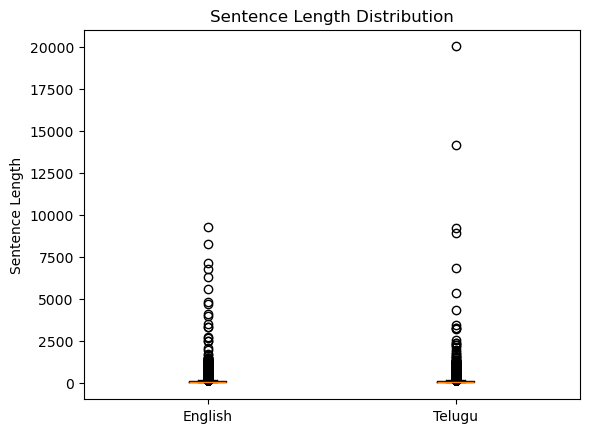

In [773]:
import matplotlib.pyplot as plt

# Calculate sentence lengths
english_lengths = [len(sentence) for sentence in english_sentences]
telugu_lengths = [len(sentence) for sentence in telugu_sentences]

# Plot boxplots
plt.boxplot([english_lengths, telugu_lengths], labels=['English', 'Telugu'])
plt.ylabel('Sentence Length')
plt.title('Sentence Length Distribution')
plt.show()

In [774]:
# restricting the max length sentences to be allowed to 97 percentile
# Calculate sentence lengths
en_sentence_lengths = [len(sentence) for sentence in english_sentences]
te_sentence_lengths = [len(sentence) for sentence in telugu_sentences]

# Calculate desired percentile
percentile = 97
en_value = np.percentile(en_sentence_lengths, percentile)
te_value = np.percentile(te_sentence_lengths, percentile)

print(f"English sentences under {percentile}th percentile: {en_value}")
print(f"Telugu sentences under {percentile}th percentile: {te_value}")

English sentences under 97th percentile: 179.0
Telugu sentences under 97th percentile: 170.0


In [775]:
# passing sentences only which have characters in vocab

# def is_valid_tokens(sentences, vocab):
#     for token in list(set(sentences)):
#         if token not in vocab:
#             return False
#     return True

def is_valid_tokens(sentence, vocab, oov_threshold=0.3):
    oov_count = sum(1 for token in sentence if token not in vocab)
    oov_ratio = oov_count / len(sentence)
    return oov_ratio <= oov_threshold


# passing sentences only if they have length less then the max sequence length
def is_valid_length(sentence, max_seq_length):
    return len(list(sentence)) < (max_seq_length - 1)

In [776]:
valid_sentence_indices = []

for index in range(len(telugu_sentences)):
    telugu_sentence, english_sentence = telugu_sentences[index], english_sentences[index]
    if is_valid_length(telugu_sentence, max_seq_length)\
    and is_valid_length(telugu_sentence, max_seq_length)\
        and is_valid_tokens(telugu_sentence, telugu_vocab):
        valid_sentence_indices.append(index)

2423581

In [777]:
print(f"Number of sentences taken: {len(english_sentences)}")
print(f"Number of Valid Sentences - {len(valid_sentence_indices)}")

Number of sentences taken: 2473018
Number of Valid Sentences - 2423581


In [778]:
valid_telugu_sentences = [telugu_sentences[i] for i in valid_sentence_indices]
valid_english_sentences = [english_sentences[i] for i in valid_sentence_indices]

valid_english_sentences[-3:], valid_telugu_sentences[-3:]

(['The investigation of the case has been taken up. ',
  'The bodies have been taken to Osmania Hospital for post-mortem. ',
  'A light rain is falling. '],
 ['కేసు దర్యాప్తు వేగవంతం చేశారు. ',
  'మృతదేహాలను పోస్టుమార్టమ్ నిమిత్తం ఉస్మానియాకు తరలించారు. ',
  'చిన్నచిన్నగా వాన చినుకులు పడుతున్నాయి. '])

#### Create passing mask, look ahead mask

In [779]:
NEG_INFTY = 1e-9

In [ ]:
def create_padding_mask(sequence_lengths, max_seq_length):
    """
    1. Initialize a tensor mask with shape (batch_size, max_seq_length) filled with True values.
    2. Iterate through each sequence length in sequence_lengths.
    3. For each sequence, set the first length positions in the corresponding row of mask to False - mask[i, :length] = False
    it goes to nth row and from nth row , untill nth column value it marks false indicating valid values.
    """
    batch_size = len(sequence_lengths)
    mask = torch.ones((batch_size, max_seq_length), dtype=torch.bool)

    for i, length in enumerate(sequence_lengths):
        mask[i, :length] = False  # Set valid sequence positions to False

    return mask

# if max_seq_length = 5, batch_size = 3
# seq_length = [3,2,4]
# expand(batch_size, max_seq_length)
# [
#     [0, 1, 2, 3, 4],
#     [0, 1, 2, 3, 4],
#     [0, 1, 2, 3, 4]
# ]

# torch.tensor(sequence_lengths).unsqueeze(1)
# [
#     [3],
#     [2],
#     [4]
# ]
# >= compares each sequence index with corresponding sequence length.

# [
#     [False, False, False, True, True],
#     [False, False, True, True, True],
#     [False, False, False, False, True]
# ]
# False represnts actual tokens and True represents padding tokens

In [781]:
def create_look_ahead_mask(max_seq_length):
    """ Creates a look ahead mask to block future tokens in the sequnce"""
    return torch.triu(torch.ones((max_seq_length, max_seq_length), dtype = torch.bool), diagonal=1)

In [ ]:
def pad_sequence(sequence, max_seq_length, pad_token_id):

    pad_length = max_seq_length - len(sequence)
    if pad_length > 0:
        return sequence + [pad_token_id] * pad_length
    else:
        return sequence[:max_seq_length]


def prepare_data(data, tokenizer, max_seq_length, pad_token_id):
    """Prepares data by tokenizing and padding sequences to max_seq_length."""
    # Tokenize and pad sequences
    encoder_inputs = tokenizer(
        data["source"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_seq_length, 
        return_tensors="pt"
    )
    decoder_inputs = tokenizer(
        data["target"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_seq_length, 
        return_tensors="pt"
    )

    # Extract inputs and attention masks
    encoder_input_ids = encoder_inputs["input_ids"]
    encoder_attention_mask = encoder_inputs["attention_mask"]
    decoder_input_ids = decoder_inputs["input_ids"]
    decoder_attention_mask = decoder_inputs["attention_mask"]

    return encoder_input_ids, encoder_attention_mask, decoder_input_ids, decoder_attention_mask

In [782]:
def create_masks(english_sentences, telugu_sentences, max_seq_length):

    """
    Create padding and look-ahead masks for a batch of sentences.
    Args:
        english_sentences: List of tokenized English sentences (with padding).
        telugu_sentences: List of tokenized Telugu sentences (with padding).
        max_seq_len: Maximum sequence length.
    Returns:
        encoder_mask: Encoder padding mask for self-attention.
        decoder_self_attention_mask: Combined padding + look-ahead mask.
        cross_attention_mask: Decoder-to-encoder padding mask.
    """
    # calculate the sequnce length
    eng_seq_length = [len(seq) for seq in english_sentences]
    tel_seq_length = [len(seq) for seq in telugu_sentences]

    # Create padding masks
    encoder_padding_mask = create_padding_mask(sequence_lengths=eng_seq_length, max_seq_length= max_seq_length) # [batch_size, max_seq_len]
    decoder_padding_mask = create_padding_mask(tel_seq_length, max_seq_length) # [batch_size, max_seq_len]

    # Expand encoder padding mask to match the shape of input for multiheaded self attention
    encoder_mask = encoder_padding_mask.unsqueeze(1).unsqueeze(2) # [batch_size, 1, 1, max_seq_len]

    # Create look ahead mask
    look_ahead_mask = create_look_ahead_mask(max_seq_length) # [max_seq_len, max_seq_len]

    # Combine decoder padding mask with look ahead mask for decoder self attention
    decoder_self_attention_mask = (look_ahead_mask.unsqueeze(0) | decoder_padding_mask.unsqueeze(1)) #[batch_size, max_seq_len, max_seq_len]

    # Expand decoder padding mask to match for cross attention
    cross_attention_mask = decoder_padding_mask.unsqueeze(1).unsqueeze(2) # [batch_size, 1, 1, max_seq_len]

    # Apply negative inf values for the masked positions
    encoder_mask = encoder_mask.float().masked_fill(mask= encoder_mask, value = NEG_INFTY)
    decoder_self_attention_mask = decoder_self_attention_mask.float().masked_fill(mask = decoder_self_attention_mask, value=NEG_INFTY)
    cross_attention_mask = cross_attention_mask.float().masked_fill(mask = cross_attention_mask, value= NEG_INFTY)

    return encoder_mask, decoder_self_attention_mask, cross_attention_mask

    

In [827]:
class UnifiedTokenizer:
    def __init__(self,
                 english_vocab,
                 telugu_vocab,
                 max_seq_length, 
                 unk_token=UNK_TOKEN, 
                 padding_token=PADDING_TOKEN, 
                 start_token=START_TOKEN, 
                 end_token=END_TOKEN):
        self.padding_token = padding_token
        self.english_vocab = english_vocab
        self.telugu_vocab = telugu_vocab
        self.english_vocab_dict = {token: idx for idx, token in enumerate(english_vocab)}
        self.telugu_vocab_dict = {token:idx for idx, token in enumerate(telugu_vocab)}
        # create a common padding token for both the vocab
        shared_padding_index = max(len(self.english_vocab_dict), len(self.telugu_vocab_dict)) + 1
        self.english_vocab_dict[self.padding_token] = shared_padding_index
        self.telugu_vocab_dict[self.padding_token] = shared_padding_index
        self.max_seq_length = max_seq_length
        self.unk_token = unk_token
        self.start_token = start_token
        self.end_token = end_token


        # Telugu-specific characters
        self.diacritics = ["ా", "ి", "ీ", "ు", "ూ", "ె", "ే", "ై", "ొ", "ో", "ౌ", "ం", "ః"]
        self.special_chars = ["౦", "౧", "౨", "౩", "౪", "౫", "౬", "౭", "౮", "౯"]

    def word_decompose(self, word):
        """Decomposes a Telugu word into its constituent characters."""
        return list(word)

    def reconstruct(self, tokens):
        """Reconstructs a word from its decomposed tokens."""
        return "".join(tokens)

    # def tokenize(self, sentence, language, add_start_token=False, add_end_token=False):
    #     """
    #     Tokenizes a sentence, applying language-specific rules.
    #     Args:
    #         sentence: The sentence to tokenize.
    #         language: "english" or "telugu".
    #         add_start_token: Whether to add a start token.
    #         add_end_token: Whether to add an end token.
    #     Returns:
    #         tokens: A list of tokens with special tokens and padding.
    #     """

    #     words = sentence.split()
    #     tokens = []

    #     if language == "telugu":
    #         # Tokenize Telugu sentence
    #         for word in words:
    #             if word in self.telugu_vocab_dict:
    #                 tokens.append(word)  # Direct match
    #             else:
    #                 # Decompose and tokenize at the character level
    #                 decomposed = self.word_decompose(word)
    #                 for char in decomposed:
    #                     tokens.append(char if char in self.telugu_vocab_dict else self.unk_token)
    #     elif language == "english":
    #         # Tokenize English sentence (word-level only)
    #         words = [word.lower() for word in words]
    #         for word in words:
    #             tokens.append(word if word in self.english_vocab_dict else self.unk_token)

    #     # Add special tokens if specified
    #     if add_start_token:
    #         tokens.insert(0, self.start_token)
    #     if add_end_token:
    #         tokens.append(self.end_token)

    #     # Add padding tokens to ensure uniform length
    #     while len(tokens) < self.max_seq_length:
    #         tokens.append(self.padding_token)

    #     # Truncate if the length exceeds max_seq_length
    #     tokens = tokens[:self.max_seq_length]

    #     return tokens
    
    # def tokenize(self, sentence, language, add_start_token = False, add_end_token = False):
    #     # if the input is a list of sentances, tokenize each sentence in the list
    #     if isinstance(sentence, list):
    #         tokens = []
    #         for s in sentence:
    #             tokens.append(self.tokenize_single_sentence(s, language, add_start_token, add_end_token))
    #         return tokens
    #     else:
    #         return self.tokenize_single_sentence(sentence, language, add_start_token, add_end_token)


    def tokenize(self, sentence, language, add_start_token=False, add_end_token=False):
        
        tokens = []
        words = sentence.split()

        if language == "telugu":
            for word in words:
                if word in self.telugu_vocab_dict:
                    # Direct match
                    tokens.append(word)
                else:
                    # Decompose the word
                    decomposed = self.word_decompose(word)
                    char_indices = []
                    for char in decomposed:
                        if char in self.telugu_vocab_dict:
                            char_indices.append(self.telugu_vocab_dict[char])
                        else:
                            char_indices.append(self.telugu_vocab_dict[self.unk_token])

                    # Check if all characters matched
                    if all(idx != self.telugu_vocab_dict[self.unk_token] for idx in char_indices):
                        # Reconstruct the word by combining indices (optional)
                        tokens.extend(decomposed)  # Add decomposed characters as tokens
                    else:
                        # If even one character didn't match, return `[UNK]` for the word
                        tokens.append(self.unk_token)

        elif language == "english":
            # English tokenization remains unchanged
            words = [word.lower() for word in words]
            for word in words:
                tokens.append(word if word in self.english_vocab_dict else self.unk_token)

        # Add special tokens
        if add_start_token:
            tokens.insert(0, self.start_token)
        if add_end_token:
            tokens.append(self.end_token)

        # Add padding
        while len(tokens) < self.max_seq_length:
            tokens.append(self.padding_token)

        # Truncate
        tokens = tokens[:self.max_seq_length]

        return tokens


    def encode(self, tokens, language):
        """Encode token indices into embedding"""

        if language == "english":
            vocab_dict = self.english_vocab_dict
        elif language == "telugu":
            vocab_dict = self.telugu_vocab_dict

        return [vocab_dict.get(token, vocab_dict.get(self.unk_token)) for token in tokens]
    
    # def decode(self, indices, language):
    #     """ Decodes indices back into tokens"""

    #     if language == "english":
    #         reversed_vocab_dict = {idx:token for token, idx in self.english_vocab_dict.items()}
    #         tokens = [reversed_vocab_dict.get(idx, self.unk_token) for idx in indices]
    #         # Join English tokens with spaces (skip special tokens)
    #         return " ".join([token for token in tokens if token not in [self.start_token, self.end_token, self.padding_token]]) 

    #     elif language == "telugu":
    #         reverse_vocab_dict = {idx: token for token, idx in self.telugu_vocab_dict.items()}
    #         tokens = [reverse_vocab_dict.get(idx, self.unk_token) for idx in indices]
    #         # Reconstruct Telugu sentence
    #         return self.reconstruct(tokens)
        
    def decode(self, indices, language):

        """ Decodes indices back into tokens """
        if language == "english":
           reversed_vocab_dict = {idx: token for token, idx in self.english_vocab_dict.items()}
           tokens = [reversed_vocab_dict.get(idx, self.unk_token) for idx in indices]
           # Join English tokens with spaces (skip special tokens)
           return " ".join([token for token in tokens if token not in [self.start_token, self.end_token, self.padding_token]])

        elif language == "telugu":
            reverse_vocab_dict = {idx: token for token, idx in self.telugu_vocab_dict.items()}
            tokens = [reverse_vocab_dict.get(idx, self.unk_token) for idx in indices]
            # Filter out special tokens
            tokens = [token for token in tokens if token not in [self.start_token, self.end_token, self.padding_token]]
            # Reconstruct with spaces between words
            return " ".join(tokens)  # Telugu-specific reconstruction
        
        

    @property
    def pad_token_index(self):
        # Return the padding token index for the relevant vocabulary
        if self.padding_token in self.english_vocab_dict:
            return self.english_vocab_dict[self.padding_token]
        elif self.padding_token in self.telugu_vocab_dict:
            return self.telugu_vocab_dict[self.padding_token]
        else:
            raise ValueError("Padding token is not in either vocabulary.")



In [828]:
# Creating custom Dataset
from torch.utils.data import DataLoader, Dataset

class TextData(Dataset):
    def __init__(self, english_sentences, telugu_sentences, tokenizer, max_seq_length, pad_token_idx):
        super().__init__()
        self.english_sentences = english_sentences
        self.telugu_sentences = telugu_sentences
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.pad_token_idx = pad_token_idx  # Padding token index shared across both vocabularies

    def __len__(self):
        return len(self.english_sentences)
    
    def __getitem__(self, idx):
        english_sentence = self.english_sentences[idx]
        telugu_sentence = self.telugu_sentences[idx]

        # Tokenize and pad
        english_tokens = self.tokenizer.tokenize(
            english_sentence, language="english", add_start_token=False, add_end_token=False
        )
        telugu_tokens = self.tokenizer.tokenize(
            telugu_sentence, language="telugu", add_start_token=True, add_end_token=True
        )

        # Encode tokens to indices
        english_indices = self.tokenizer.encode(english_tokens, language="english")
        telugu_indices = self.tokenizer.encode(telugu_tokens, language="telugu")

        # Pad sequences to max_seq_length
        english_indices = self.pad_sequence(english_indices)
        telugu_indices = self.pad_sequence(telugu_indices)

        return torch.tensor(english_indices, dtype=torch.long), torch.tensor(telugu_indices, dtype=torch.long)


    def pad_sequence(self, tokens):
        """Pad or truncate tokens to max_seq_length."""
        if len(tokens) > self.max_seq_length:
            tokens = tokens[:self.max_seq_length]  # Truncate if tokens exceed max_seq_length
        elif len(tokens) < self.max_seq_length:
            tokens += [self.pad_token_idx] * (self.max_seq_length - len(tokens))  # Pad to max_seq_length

        return tokens

In [838]:
sample_english_vocab = [
    "[PAD]", "[UNK]", "[SOS]", "[EOS]", 
    "hello", "this", "is",
    "a", "test", "example", "sentence", 
    "how", "are", "you", "doing", 
    "today", "good", "morning", "night"
]

sample_telugu_vocab = [
    "[PAD]", "[UNK]", "[SOS]", "[EOS]", 
    "హలో", "ఇది", "ఒక",
    "పరీక్ష", "ఉదాహరణ", "వాక్యం", 
    "ఎలా", "ఉన్నావు", "నువ్వు", 
    "చేస్తున్నావు", "ఈరోజు", 
    "శుభోదయం", "శుభరాత్రి"
]

In [855]:
# Define special tokens
PAD_TOKEN = "[PAD]"
UNK_TOKEN = "[UNK]"
SOS_TOKEN = "[SOS]"
EOS_TOKEN = "[EOS]"
# Define max sequence length
sample_MAX_SEQ_LENGTH = 20

# Initialize tokenizer
sample_tokenizer = UnifiedTokenizer(
    english_vocab=sample_english_vocab,
    telugu_vocab=sample_telugu_vocab,
    max_seq_length=sample_MAX_SEQ_LENGTH,
    unk_token=UNK_TOKEN,
    padding_token=PAD_TOKEN,
    start_token=SOS_TOKEN,
    end_token=EOS_TOKEN
)

# Sample sentences for testing
sample_english_sentence = 'Hello, how are you?'
sample_telugu_sentence = 'హలో, మీరు ఎలా ఉన్నారు?'
                          


dataset = TextData(english_sentences= sample_english_sentence,
                   telugu_sentences= sample_telugu_sentence,
                   tokenizer= sample_tokenizer,
                   max_seq_length= sample_MAX_SEQ_LENGTH,
                   pad_token_idx=sample_tokenizer.pad_token_index)


In [856]:
english_tokens = sample_tokenizer.tokenize(sample_english_sentence, language="english", add_start_token=False, add_end_token=False)
telugu_tokens = sample_tokenizer.tokenize(sample_telugu_sentence, language="telugu", add_start_token=True, add_end_token=True)

In [857]:
english_indices = sample_tokenizer.encode(english_tokens, language="english")
telugu_indices = sample_tokenizer.encode(telugu_tokens, language="telugu")

print("Telugu Tokens:", telugu_tokens)
print("Telugu Indices:", telugu_indices)
print("English Indices", english_indices)
print("English Tokens", english_tokens)
print("Decoded Telugu:", sample_tokenizer.decode(telugu_indices, language="telugu"))
print("Decoded English:", sample_tokenizer.decode(english_indices, language="english"))

# Verify padding and decoding
assert sample_tokenizer.pad_token_index in english_indices
assert sample_tokenizer.pad_token_index in telugu_indices

for english, telugu in dataset:
    print("English indices:", english_indices)
    print("Telugu indices:", telugu_indices)
    print("Decoded English:", [sample_english_vocab[idx] for idx in english_indices])
    print("Decoded Telugu:", [sample_telugu_vocab[idx] for idx in telugu_indices])
    print("---")

Telugu Tokens: ['[SOS]', '[UNK]', '[UNK]', 'ఎలా', '[UNK]', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Telugu Indices: [2, 1, 1, 10, 1, 3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
English Indices [1, 11, 12, 1, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
English Tokens ['[UNK]', 'how', 'are', '[UNK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Decoded Telugu: [UNK] [UNK] ఎలా [UNK]
Decoded English: [UNK] how are [UNK]
English indices: [1, 11, 12, 1, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Telugu indices: [2, 1, 1, 10, 1, 3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


IndexError: list index out of range

In [351]:
# sample_english_sentence = "This is a hello sentence"
# sample_sentence_tokens = tokenizer.tokenize(sample_english_sentence, language="english", add_start_token=True, add_end_token=True)
# print(sample_sentence_tokens)

In [785]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 32
max_seq_length = 200
ffn_hidden = 2048
num_layers = 5

In [858]:
# Define vocabularies
sample_english_vocab = [
    "[PAD]", "[UNK]", "[SOS]", "[EOS]", 
    "hello", "this", "is",
    "a", "test", "example", "sentence", 
    "how", "are", "you", "doing", 
    "today", "good", "morning", "night"
]

sample_telugu_vocab = [
    "[PAD]", "[UNK]", "[SOS]", "[EOS]", 
    "హలో", "ఇది", "ఒక",
    "పరీక్ష", "ఉదాహరణ", "వాక్యం", 
    "ఎలా", "ఉన్నావు", "నువ్వు", 
    "చేస్తున్నావు", "ఈరోజు", 
    "శుభోదయం", "శుభరాత్రి"
]

# Define special tokens
PAD_TOKEN = "[PAD]"
UNK_TOKEN = "[UNK]"
SOS_TOKEN = "[SOS]"
EOS_TOKEN = "[EOS]"

# Define max sequence length
sample_MAX_SEQ_LENGTH = 20

# Initialize tokenizer
tokenizer = UnifiedTokenizer(
    english_vocab=sample_english_vocab,
    telugu_vocab=sample_telugu_vocab,
    max_seq_length=sample_MAX_SEQ_LENGTH,
    unk_token=UNK_TOKEN,
    padding_token=PAD_TOKEN,
    start_token=SOS_TOKEN,
    end_token=EOS_TOKEN
)

# Sample sentences for testing
sample_english_sentence = ["hello world this is a test", "hello world this is a test", "hello world this is a test"]
sample_telugu_sentence = ["హలో ప్రపంచం ఇది ఒక పరీక్ష", "హలో ప్రపంచం ఇది ఒక పరీక్ష", "హలో ప్రపంచం ఇది ఒక పరీక్ష"]

dataset = TextData(english_sentences= sample_english_sentence,
                   telugu_sentences= sample_telugu_sentence,
                   tokenizer= tokenizer,
                   max_seq_length= sample_MAX_SEQ_LENGTH,
                   pad_token_idx=tokenizer.pad_token_index)



In [859]:
tokenizer.pad_token_index, tokenizer.start_token, tokenizer.end_token, tokenizer.unk_token, dataset.pad_token_idx

(20, '[SOS]', '[EOS]', '[UNK]', 20)

In [860]:
# Test the dataset
for english, telugu in dataset:
    print("English indices:", english)
    print("Telugu indices:", telugu)
    print("Decoded English:", [sample_english_vocab[idx] for idx in english])
    print("Decoded Telugu:", [sample_telugu_vocab[idx] for idx in telugu])
    print("---")

English indices: tensor([ 4,  1,  5,  6,  7,  8, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20])
Telugu indices: tensor([ 2,  4,  1,  5,  6,  7,  3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20])


IndexError: list index out of range

In [861]:
sample_train_dataloader = DataLoader(
    dataset, batch_size=32, drop_last=True
)

In [862]:

# Tokenize English
english_tokens = tokenizer.tokenize(sample_english_sentence, language="english", add_start_token=True, add_end_token=True)
print("English Tokens:", english_tokens)

# Encode English
english_encoded = tokenizer.encode(english_tokens, language="english")
print("Encoded English:", english_encoded)

# Decode English
english_decoded = tokenizer.decode(english_encoded, language="english")
print("Decoded English:", english_decoded)

# Tokenize Telugu
telugu_tokens = tokenizer.tokenize(sample_telugu_sentence, language="telugu", add_start_token=True, add_end_token=True)
print("Telugu Tokens:", telugu_tokens)

# Encode Telugu
telugu_encoded = tokenizer.encode(telugu_tokens, language="telugu")
print("Encoded Telugu:", telugu_encoded)

# Decode Telugu
telugu_decoded = tokenizer.decode(telugu_encoded, language="telugu")
print("Decoded Telugu:", telugu_decoded)

# Define embedding layer
embedding_layer = nn.Embedding(num_embeddings=len(english_vocab + telugu_vocab), embedding_dim=d_model)


AttributeError: 'list' object has no attribute 'split'

In [789]:
len(english_vocab), len(telugu_vocab), max_seq_length, len(valid_english_sentences), len(valid_telugu_sentences)

(1283, 1012, 200, 2423581, 2423581)

In [791]:
valid_english_sentences = valid_english_sentences[:1000]
valid_telugu_sentences = valid_telugu_sentences[:1000]
valid_english_sentences[:3], valid_telugu_sentences[:3]

(['Have you heard about Foie gras? ',
  'I never thought of acting in films. ',
  'Installed Software '],
 ['ఇక ఫ్రూట్ ఫ్లైస్ గురించి మీరు విన్నారా? ',
  'సూర్య సినిమాల్లో నటించాలని ఎప్పుడూ అనుకోలేదు. ',
  'స్థాపించబడిన సాఫ్ట్\u200dవేర్ '])

In [847]:
# Initialzing for Tokenizer and Dataset

final_tokenizer = UnifiedTokenizer(english_vocab= sample_english_vocab, 
                             telugu_vocab= sample_telugu_vocab, 
                             max_seq_length= max_seq_length,
                             unk_token= UNK_TOKEN,
                             padding_token= PADDING_TOKEN,
                             start_token= START_TOKEN,
                             end_token= END_TOKEN)

final_dataset = TextData(english_sentences= sample_english_sentence,
                   telugu_sentences= sample_telugu_sentence,
                   tokenizer= sample_tokenizer,
                   max_seq_length= max_seq_length,
                   pad_token_idx=final_tokenizer.pad_token_index)

In [848]:
train_dataloader = DataLoader(
    final_dataset, batch_size=32, drop_last=True
)

for english_batch, telugu_batch in train_dataloader:
    assert english_batch.shape[0] == telugu_batch.shape[0] == 32, "Batch size mismatch in dataloader!"


# Initiliaze Position Encoder
position_encoder = PositionEncoding(d_model= d_model, max_seq_length= max_seq_length)

In [871]:
for english_batch, telugu_batch in train_dataloader:
    english_indices = [sample_tokenizer.encode(tokens, language="english") for tokens in english_batch]
    telugu_indices = [sample_tokenizer.encode(tokens, language="telugu") for tokens in telugu_batch]
    print(f"English indices batch size: {len(english_indices)}")
    print(f"Telugu indices batch size: {len(telugu_indices)}")
    print(f"Max lengths: English={max(len(seq) for seq in english_indices)}, Telugu={max(len(seq) for seq in telugu_indices)}")

In [872]:
# Define embedding layer
embedding_layer = nn.Embedding(num_embeddings=len(english_vocab + telugu_vocab), embedding_dim=d_model)


for english_batch, telugu_batch in train_dataloader:
    # Encode tokens to indices
    english_indices = [sample_tokenizer.encode(tokens, language="english") for tokens in english_batch]
    telugu_indices = [sample_tokenizer.encode(tokens, language="telugu") for tokens in telugu_batch]
    
    # Convert indices into torch tensor
    english_tensor = torch.tensor(english_indices, dtype=torch.long)
    telugu_tensor = torch.tensor(telugu_indices, dtype=torch.long)

    print(f"English Tensor Shape: {english_tensor.shape}")
    print(f"Telugu Tensor Shape: {telugu_tensor.shape}")

    # Add embedding layer (convert indices to embeddings)
    english_embedded = embedding_layer(english_tensor)  # Shape: [batch_size, seq_len, d_model]
    telugu_embedded = embedding_layer(telugu_tensor)  # Shape: [batch_size, seq_len, d_model]

    print(f"Embedded English Shape: {english_embedded.shape}")  # Expected: [batch_size, seq_len, d_model]
    print(f"Embedded Telugu Shape: {telugu_embedded.shape}") 

    # Add Position embeddings
    english_position_encoded_tensor = position_encoder(english_embedded)
    telugu_position_encoded_tensor = position_encoder(telugu_embedded)

    print(f"Position Encoded English Tensor Shape: {english_position_encoded_tensor.shape}")
    print(f"Position Encoded Telugu Tensor Shape: {telugu_position_encoded_tensor.shape}")

    # Create Masks
    encoder_mask, decoder_self_attention_mask, cross_attention_mask = create_masks(english_sentences=english_tensor,
                                                                                   telugu_sentences=telugu_tensor,
                                                                                   max_seq_length=max_seq_length)

In [873]:
encoder_mask.shape, decoder_self_attention_mask.shape, cross_attention_mask.shape

(torch.Size([32, 1, 1, 200]),
 torch.Size([32, 200, 200]),
 torch.Size([32, 1, 1, 200]))

In [874]:
english_tensor.shape, telugu_tensor.shape, english_embedded.shape, telugu_embedded.shape, english_position_encoded_tensor.shape, telugu_position_encoded_tensor.shape

(torch.Size([32, 200]),
 torch.Size([32, 200]),
 torch.Size([32, 200, 512]),
 torch.Size([32, 200, 512]),
 torch.Size([32, 200, 512]),
 torch.Size([32, 200, 512]))

In [875]:
print("Padding Token Index:", sample_tokenizer.pad_token_index)
print("Unique Indices in English Tensor:", torch.unique(english_tensor[20]))
print("Unique Indices in Telugu Tensor:", torch.unique(telugu_tensor[20]))

Padding Token Index: 20
Unique Indices in English Tensor: tensor([1282])
Unique Indices in Telugu Tensor: tensor([1011])


In [876]:
print("English Tensor Sample (first batch):")
print(english_tensor[1])  # Check for presence of padding tokens
print(telugu_tensor[1])

English Tensor Sample (first batch):
tensor([1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
        1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282, 1282,
   

In [878]:
print("Encoder Mask [1]:")
print(encoder_mask[1])  # This will show the mask applied for the first sequence

print("Cross Attention Mask [1]:")
print(cross_attention_mask[1])  # Same for cross attention


Encoder Mask [1]:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Cross Attention Mask [1]:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [879]:
# Debugging mask logic
padding_indices = (english_tensor == tokenizer.pad_token_index)  # Compare with padding token index
print("Padding Indices:", padding_indices)

Padding Indices: tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [880]:
print("Padding Token Index:", tokenizer.pad_token_index)
print("Unique Indices in Tensor:", torch.unique(english_tensor))

Padding Token Index: 20
Unique Indices in Tensor: tensor([1282])


In [881]:
padding_indices = (english_tensor == tokenizer.pad_token_index)  # Boolean mask for padding
print("Padding Indices Shape:", padding_indices.shape)
print("Number of Padding Tokens:", padding_indices.sum().item())

Padding Indices Shape: torch.Size([32, 200])
Number of Padding Tokens: 0


In [882]:
encoder_mask = (~padding_indices).unsqueeze(1).unsqueeze(2).to(torch.float32)
print("Encoder Mask Shape:", encoder_mask.shape)
print("Sample Encoder Mask:", encoder_mask[0, 0, :])

Encoder Mask Shape: torch.Size([32, 1, 1, 200])
Sample Encoder Mask: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])


In [883]:
cross_attention_mask = (~padding_indices).unsqueeze(1).unsqueeze(3).to(torch.float32)
print("Cross Attention Mask Shape:", cross_attention_mask.shape)
print("Sample Cross Attention Mask:", cross_attention_mask[0, 0, :, :])

Cross Attention Mask Shape: torch.Size([32, 1, 200, 1])
Sample Cross Attention Mask: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
     

In [884]:
for i in range(batch_size):
    print(f"Batch {i} Encoder Mask:")
    print(encoder_mask[i])
    print(f"Batch {i} Cross Attention Mask:")
    print(cross_attention_mask[i].shape)


Batch 0 Encoder Mask:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])
Batch 0 Cross Attention Mask:
torch.Size([1, 200, 1])
B

In [885]:
print("Encoder Mask Shape:", encoder_mask.shape)  # Expected: [32, 1, 1, 200]
print("Cross Attention Mask Shape:", cross_attention_mask.shape)  # Expected: [32, 1, 200, 1]

Encoder Mask Shape: torch.Size([32, 1, 1, 200])
Cross Attention Mask Shape: torch.Size([32, 1, 200, 1])


In [886]:
english_unique = torch.unique(english_tensor)
telugu_unique = torch.unique(telugu_tensor)
shared_indices = set(english_unique.tolist()) & set(telugu_unique.tolist())
print("Shared Indices (should only include padding token index):", shared_indices)

Shared Indices (should only include padding token index): set()


In [887]:
shared_indices = {2, 1146, 95}  # The indices you've identified

print("Shared Tokens in English Vocabulary:")
for idx in shared_indices:
    print(f"Index {idx}: {tokenizer.english_vocab_dict.get(idx, 'Unknown')}")

print("\nShared Tokens in Telugu Vocabulary:")
for idx in shared_indices:
    print(f"Index {idx}: {tokenizer.telugu_vocab_dict.get(idx, 'Unknown')}")

Shared Tokens in English Vocabulary:
Index 2: Unknown
Index 1146: Unknown
Index 95: Unknown

Shared Tokens in Telugu Vocabulary:
Index 2: Unknown
Index 1146: Unknown
Index 95: Unknown


In [888]:
print("English OOV Token Index:", tokenizer.english_vocab_dict.get(tokenizer.unk_token, "Not Found"))
print("Telugu OOV Token Index:", tokenizer.telugu_vocab_dict.get(tokenizer.unk_token, "Not Found"))


English OOV Token Index: 1
Telugu OOV Token Index: 1


In [889]:
# Check the raw tokenized outputs before conversion to indices
print("Raw English Tokens for Sample 22:", tokenizer.decode(english_tensor[22].tolist(), language="english"))
print("Raw Telugu Tokens for Sample 22:", tokenizer.decode(telugu_tensor[22].tolist(), language="telugu"))


Raw English Tokens for Sample 22: [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 

### Defining the Transformer Class and defining Training Loop and the rest

In [890]:
class Transformer(nn.Module):
    def __init__(self, 
                 d_model, 
                 num_heads, 
                 ffn_hidden, 
                 drop_prob, 
                 num_layers, 
                 tokenizer, 
                 max_seq_length):
        super().__init__()
        self.encoder = EncoderBlock(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
        self.decoder = DecoderLayer(d_model, ffn_hidden, drop_prob, num_heads)
        self.output_layer = nn.Linear(d_model, len(tokenizer.telugu_vocab))  # Project to Telugu vocab size

    def forward(self, 
                src_embedded,  # Position-encoded embeddings of the source (English) sequence
                tgt_embedded,  # Position-encoded embeddings of the target (Telugu) sequence
                encoder_mask, 
                decoder_self_attention_mask, 
                cross_attention_mask):
        """
        Forward pass of the Transformer model.

        Args:
            src_embedded: Position-encoded source embeddings (batch_size, seq_len_src, d_model)
            tgt_embedded: Position-encoded target embeddings (batch_size, seq_len_tgt, d_model)
            encoder_mask: Mask for the encoder (batch_size, 1, 1, seq_len_src)
            decoder_self_attention_mask: Mask for decoder's self-attention (batch_size, seq_len_tgt, seq_len_tgt)
            cross_attention_mask: Mask for decoder's cross-attention (batch_size, 1, 1, seq_len_src)

        Returns:
            logits: Unnormalized predictions for the target vocabulary (batch_size, seq_len_tgt, vocab_size)
        """
        # Pass through the encoder
        encoder_output = self.encoder(src_embedded, mask=encoder_mask)  # Shape: (batch_size, seq_len_src, d_model)

        # Pass through the decoder
        decoder_output = self.decoder(
            x=encoder_output,  # Encoder output
            y=tgt_embedded,    # Target embeddings
            decoder_self_attention_mask=decoder_self_attention_mask,
            cross_attention_mask=cross_attention_mask
        )  # Shape: (batch_size, seq_len_tgt, d_model)

        # Project to the output vocabulary space
        logits = self.output_layer(decoder_output)  # Shape: (batch_size, seq_len_tgt, vocab_size)
        return logits


### Optimizer and Loss Function

In [891]:
import torch.optim as optim
import torch.nn.functional as F

# Initialize the model
model = Transformer(d_model=d_model,
                    num_heads=num_heads,
                    ffn_hidden=ffn_hidden,
                    drop_prob=drop_prob,
                    num_layers=num_layers,
                    tokenizer=tokenizer,
                    max_seq_length=max_seq_length)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define loss function (CrossEntropyLoss for sequence-to-sequence)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_index, reduction='mean')

In [892]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 32
max_seq_length = 200
ffn_hidden = 2048
num_layers = 5

In [893]:
src_embedded = english_position_encoded_tensor  # Shape: [batch_size, seq_len, d_model]
tgt_embedded = telugu_position_encoded_tensor 

In [477]:
# Training Loop
num_epochs = 3  # You can adjust this based on your requirements
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for english_batch, telugu_batch in train_dataloader:
        
        print(encoder_mask.shape)
        print(decoder_self_attention_mask.shape)
        print(cross_attention_mask.shape)

        # Forward pass
        optimizer.zero_grad()
        logits = model(
            src_embedded,                # Position-encoded source embeddings
            tgt_embedded[:-1],           # Exclude the last token for teacher forcing
            encoder_mask,
            decoder_self_attention_mask,
            cross_attention_mask
            )  # logits: [batch_size, seq_len - 1, vocab_size]

        # Reshape logits and target for loss calculation
        logits = logits.reshape(-1, logits.size(-1))  # [batch_size * seq_len - 1, vocab_size]
        target = telugu_tensor[1:].reshape(-1)  # Shift target to exclude <sos>, [batch_size * seq_len - 1]

        # Compute loss
        loss = criterion(logits, target)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")


torch.Size([32, 1, 1, 200])
torch.Size([32, 200, 200])
torch.Size([32, 1, 200, 1])
----- Attention Layer 1 ----
x.shape = torch.Size([32, 200, 512])
x.size() = torch.Size([32, 200, 512])
x after going through qkv layer - torch.Size([32, 200, 1536])
--- Entering MultiHeadedAttention ---
qkv reshaped shape is torch.Size([32, 200, 8, 192])
QKV Permuted Shape is - torch.Size([32, 8, 200, 192])
--- Dividing QKV into individual tensors ---
Now q, k, v tensors are passed into the Attention Calculation
Initial Query shape: torch.Size([32, 8, 200, 64])
Initial Key shape: torch.Size([32, 8, 200, 64])
Initial Value shape: torch.Size([32, 8, 200, 64])
Scaled dot product (q * k^T) shape: torch.Size([32, 8, 200, 200])
Mask shape before broadcasting: torch.Size([32, 1, 1, 200])
Scaled tensor shape before adding mask: torch.Size([32, 8, 200, 200])
Mask shape before adding: torch.Size([32, 1, 1, 200])
Scaled tensor shape after adding mask: torch.Size([32, 8, 200, 200])
Attention (after softmax) shape: 

RuntimeError: The size of tensor a (31) must match the size of tensor b (32) at non-singleton dimension 0